# Exam Project in 22481

## Investigating phantoms

In [1]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.font_manager as fm
import os

# MRI

In [2]:
def load_dicom_folder(folder_path, modality=None):
    """
    Load a DICOM series from a folder into a 3D NumPy array.

    Parameters
    ----------
    folder_path : str
        Path to folder with DICOM files (all from same series).
    modality : str, optional
        "CT" or "MR" (used to decide slice order).

    Returns
    -------
    volume : np.ndarray
        3D array of stacked slices.
    header : pydicom Dataset
        Header of first slice.
    dicoms : list
        List of all DICOM datasets.
    voxel_size : tuple
        (dy, dx, dz) voxel dimensions in mm.
    """
    # Read all dicom files in folder
    dicoms = [pydicom.dcmread(os.path.join(folder_path, f))
              for f in os.listdir(folder_path)
              if not f.startswith('.')]

    # Sort by InstanceNumber
    reverse = True if modality == "CT" else False
    dicoms.sort(key=lambda d: int(d.InstanceNumber), reverse=reverse)

    # Stack into 3D volume
    if modality == "CT":
        # Convert to Hounsfield Units
        slices = []
        for d in dicoms:
            # Convert raw CT pixels to Hounsfield Units (HU)
            # HU = pixel_value * RescaleSlope + RescaleIntercept
            # Use defaults if fields are missing (slope=1, intercept=0)
            slope = getattr(d, 'RescaleSlope', 1.0)
            intercept = getattr(d, 'RescaleIntercept', 0.0)
            slices.append(d.pixel_array * slope + intercept)
        volume = np.stack(slices, axis=2)
    else:
        # MR: keep raw pixel values
        volume = np.stack([d.pixel_array for d in dicoms], axis=2)

    # Metadata
    header = dicoms[0]
    dx, dy = [float(sp) for sp in header.PixelSpacing]

    # Prefer SpacingBetweenSlices (if available) over SliceThickness
    if hasattr(header, "SpacingBetweenSlices"):
        dz = float(header.SpacingBetweenSlices)
    else:
        dz = float(header.SliceThickness)

    voxel_size = (dy, dx, dz)

    return volume, header, dicoms, voxel_size

# Paths to MR datasets (update before running!)
t1w_path = r"C:\Users\bjorn\Desktop\Spaghetti\22481exercises\A_3D_T1w\A_3D_T1w"
t2w_path = r"C:\Users\bjorn\Desktop\Spaghetti\22481exercises\A_3D_T2w\A_3D_T2w"

# Load datasets 
t1w_img3d, t1w_header, t1w_dicoms, t1w_voxel = load_dicom_folder(t1w_path, modality="MR")
t2w_img3d, t2w_header, t2w_dicoms, t2w_voxel = load_dicom_folder(t2w_path, modality="MR")

# Swap axes for these 3D datasets (collected in sagittal view)
t1w_img3d = np.transpose(t1w_img3d, (1,2,0))  
t2w_img3d = np.transpose(t2w_img3d, (1,2,0))  
t1w_voxel = (t1w_voxel[1], t1w_voxel[2], t1w_voxel[0])
t2w_voxel = (t2w_voxel[1], t2w_voxel[2], t2w_voxel[0])

print("MR T1w matrix size:", t1w_img3d.shape)
print("MR T1w voxel size (mm):", t1w_voxel)
print("MR T1w intensity range:", np.min(t1w_img3d), np.max(t1w_img3d))
print("MR T2w matrix size:", t2w_img3d.shape)
print("MR T2w voxel size (mm):", t2w_voxel)
print("MR T2w intensity range:", np.min(t2w_img3d), np.max(t2w_img3d))


MR T1w matrix size: (512, 308, 512)
MR T1w voxel size (mm): (0.4688, 0.6, 0.4688)
MR T1w intensity range: 0 1394
MR T2w matrix size: (512, 308, 512)
MR T2w voxel size (mm): (0.4688, 0.6, 0.4688)
MR T2w intensity range: 0 1772


In [3]:
t1w_header

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 184
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.514.11554579.1340214.28986.1756881717.346
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.840.113619.6.514
(0002,0013) Implementation Version Name         SH: 'MR30.1'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.840.113619.2.514.11554579.1340214.28986.1756881717.346
(0008,0020) Study Date                          DA: '20250

In [23]:
t2w_header

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 184
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.514.11554579.1340214.28986.1756881716.905
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.840.113619.6.514
(0002,0013) Implementation Version Name         SH: 'MR30.1'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.840.113619.2.514.11554579.1340214.28986.1756881716.905
(0008,0020) Study Date                          DA: '20250

In [87]:
# Extract TR (Repetition Time) and TE (Echo Time) from DICOM headers

print(f"T1w TR: {t1w_header.RepetitionTime} ms, TE: {t1w_header.EchoTime} ms")
print(f"T2w TR: {t2w_header.RepetitionTime} ms, TE: {t2w_header.EchoTime} ms")

# Extract slice count and overlap between slices

print(f"T1w slices: {t1w_header.ImagesInAcquisition}, T2w slices: {t2w_header.ImagesInAcquisition}")

print(f"T1w slice overlap: {t1w_header.SliceThickness - t1w_header.SpacingBetweenSlices} mm")
print(f"T2w slice overlap: {t2w_header.SliceThickness - t2w_header.SpacingBetweenSlices} mm")

print(f"T1w slice thickness: {t1w_header.SliceThickness} mm")
print(f"T2w slice thickness: {t2w_header.SliceThickness} mm")

print(f"T1w spacing between slices: {t1w_header.SpacingBetweenSlices} mm")
print(f"T2w spacing between slices: {t2w_header.SpacingBetweenSlices} mm")

T1w TR: 963 ms, TE: 10.464 ms
T2w TR: 4303 ms, TE: 116.872 ms
T1w slices: 308, T2w slices: 308
T1w slice overlap: 0.6 mm
T2w slice overlap: 0.6 mm
T1w slice thickness: 1.2 mm
T2w slice thickness: 1.2 mm
T1w spacing between slices: 0.6 mm
T2w spacing between slices: 0.6 mm


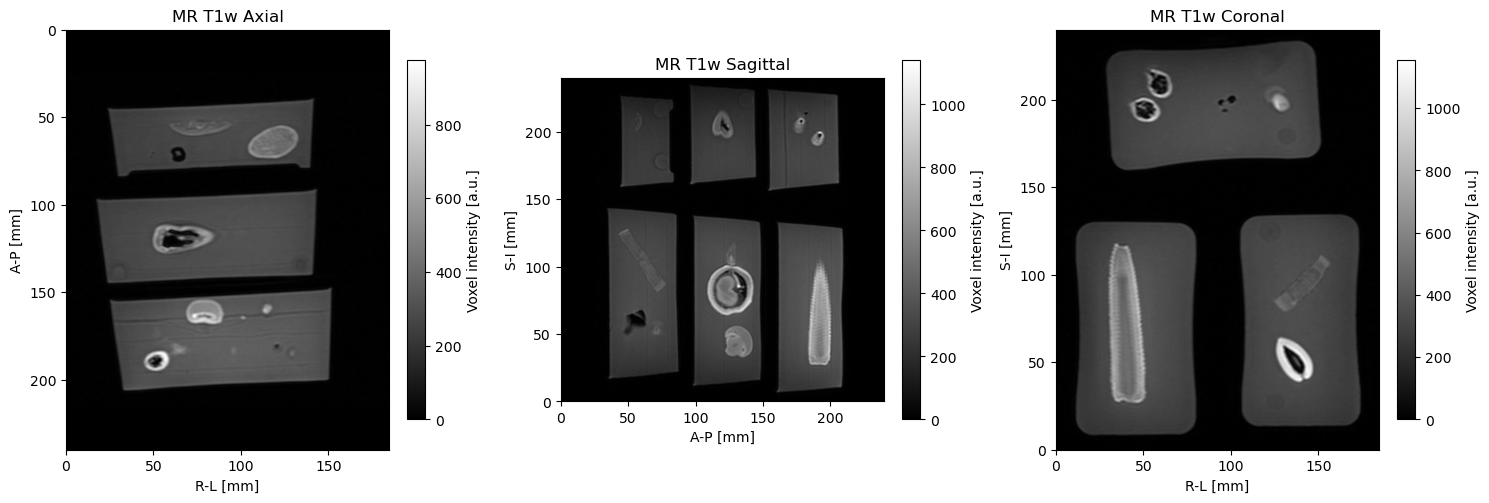

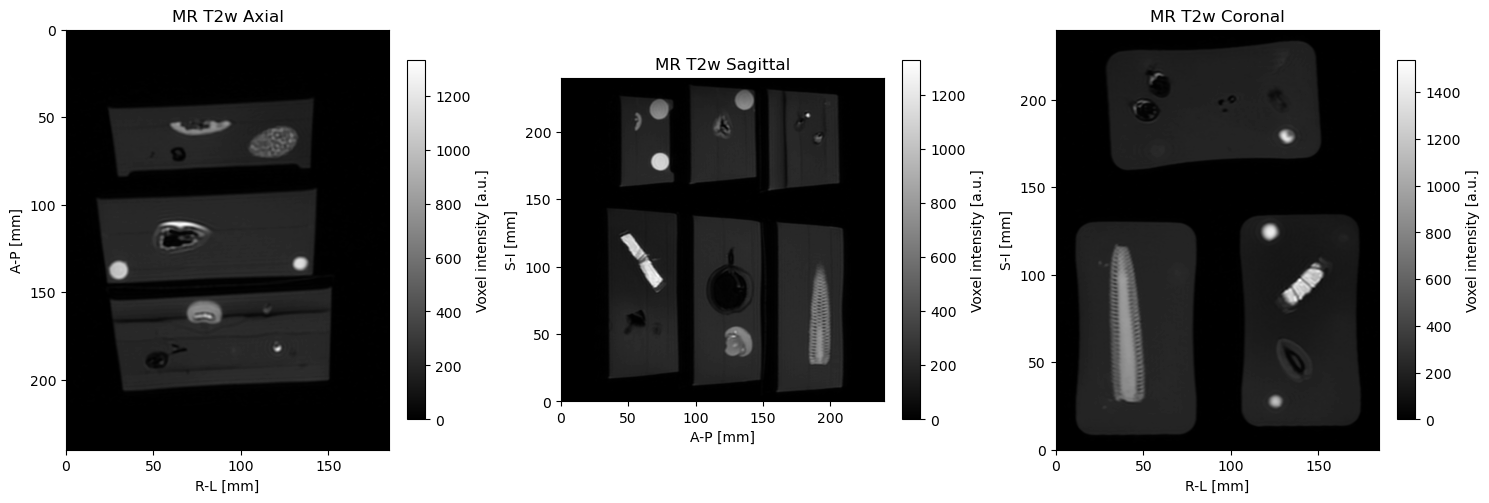

In [4]:
# Display the raw images

def show_slices(img3d, voxel_size, loc, colormap, title_prefix="", voxel_units=""):
    """Display axial, sagittal, coronal slices with correct aspect."""
    ny, nx, nz = img3d.shape

    # NB! loc is given in matrix size / grid units, whereas images are shown with axes in units of mm
    loc_AP = loc[0]
    loc_RL = loc[1]
    loc_SI = loc[2]

    # Physical lengths
    y_mm = ny * voxel_size[0]  # A-P
    x_mm = nx * voxel_size[1]  # R-L
    z_mm = nz * voxel_size[2]  # S-I

    fig, axes = plt.subplots(1, 3, figsize=(15, 10))

    # Axial
    axial = img3d[:, :, loc_SI]
    im = axes[0].imshow(axial, cmap=colormap, extent=[0, x_mm, y_mm, 0])
    axes[0].set_title(f'{title_prefix} Axial')
    axes[0].set_xlabel('R-L [mm]')
    axes[0].set_ylabel('A-P [mm]')
    plt.colorbar(im, ax=axes[0], fraction=0.05, pad=0.05, label=voxel_units)


    # Sagittal (A-P vs S-I)
    sagittal = np.rot90(img3d[:, loc_RL, :], 1)
    im = axes[1].imshow(sagittal, cmap=colormap, extent=[0, y_mm, 0, z_mm])
    axes[1].set_title(f'{title_prefix} Sagittal')
    axes[1].set_xlabel('A-P [mm]')
    axes[1].set_ylabel('S-I [mm]')
    plt.colorbar(im, ax=axes[1], fraction=0.05, pad=0.05, label=voxel_units)

    # Coronal (R-L vs S-I)
    coronal = np.rot90(img3d[loc_AP, :, :], 1)
    im = axes[2].imshow(coronal, cmap=colormap, extent=[0, x_mm, 0, z_mm])
    axes[2].set_title(f'{title_prefix} Coronal')
    axes[2].set_xlabel('R-L [mm]')
    axes[2].set_ylabel('S-I [mm]')
    plt.colorbar(im, ax=axes[2], fraction=0.05, pad=0.05, label=voxel_units)

    plt.tight_layout()
    plt.show()

# Desired location in mm [A-P, R-L, S-I]
loc_mm = np.array([190, 45, 190], dtype=float) # Coronal, Sagittal, Axial
# Convert to voxel indices (nearest integer)
loc = np.rint(loc_mm / t1w_voxel).astype(int)

colormap = 'gray'

# Show MR
show_slices(t1w_img3d, t1w_voxel, loc, colormap, title_prefix="MR T1w", voxel_units="Voxel intensity [a.u.]") # a.u. = arbitrary units
show_slices(t2w_img3d, t2w_voxel, loc, colormap, title_prefix="MR T2w", voxel_units="Voxel intensity [a.u.]") # a.u. = arbitrary units

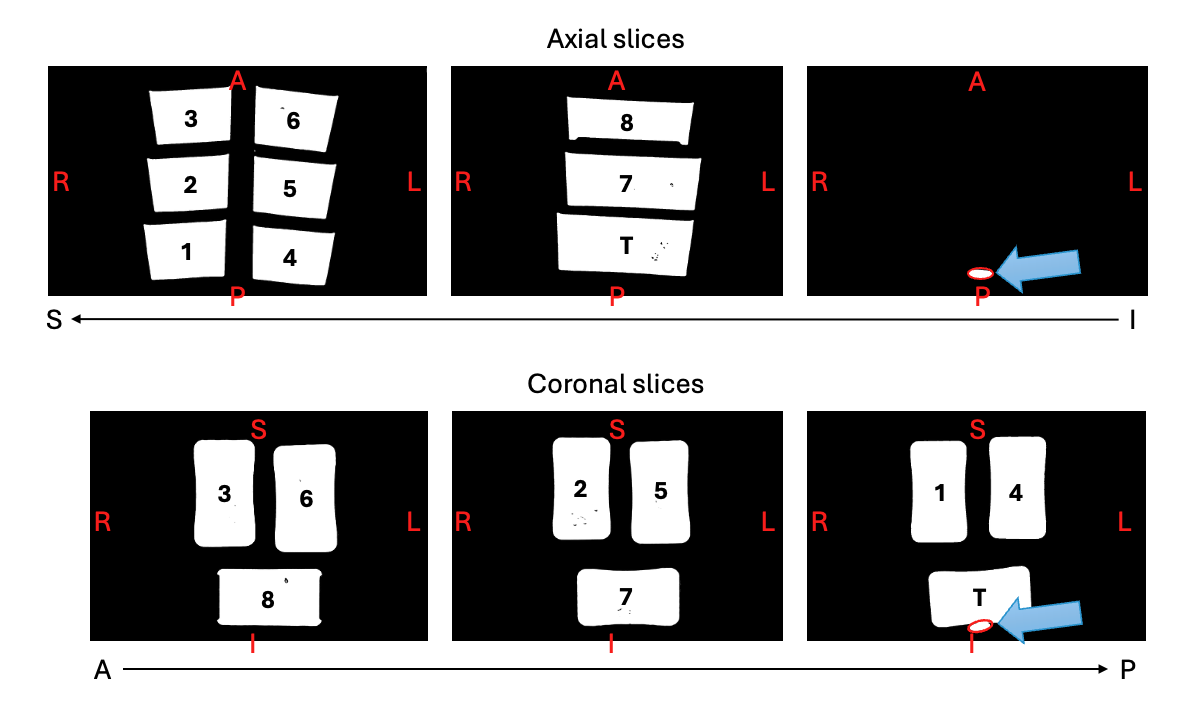

## T1

In [21]:
def show_slice(img3d, voxel_size, slice_mm, orientation,
               crop_AP_mm=None, crop_RL_mm=None, crop_SI_mm=None,
               colormap='gray', voxel_units="", title_prefix="", save_svg=False, svg_filename=None):
    """
    Show ONE MRI slice (axial, sagittal, coronal) with correct aspect
    and mm-accurate cropping. Optionally save as SVG.
    """

    # Convert crop mm → voxel index ranges
    def mm_to_idx(mm_range, vox):
        i0 = int(np.floor(mm_range[0] / vox))
        i1 = int(np.ceil(mm_range[1]  / vox))
        return slice(i0, i1)

    crop_AP = mm_to_idx(crop_AP_mm, voxel_size[0]) if crop_AP_mm else slice(None)
    crop_RL = mm_to_idx(crop_RL_mm, voxel_size[1]) if crop_RL_mm else slice(None)
    crop_SI = mm_to_idx(crop_SI_mm, voxel_size[2]) if crop_SI_mm else slice(None)

    # Convert slice location mm → voxel index
    axis_map = {"coronal":0, "sagittal":1, "axial":2}
    slice_idx = int(round(slice_mm / voxel_size[axis_map[orientation]]))

    # ==========================
    # Extract the slice
    # ==========================
    if orientation == "axial":
        img = img3d[crop_AP, crop_RL, slice_idx]
        extent = [
            crop_RL.start * voxel_size[1], crop_RL.stop * voxel_size[1],
            crop_AP.stop * voxel_size[0], crop_AP.start * voxel_size[0]
        ]
        xlabel, ylabel = "R-L [mm]", "A-P [mm]"

    elif orientation == "sagittal":
        img = img3d[crop_AP, slice_idx, crop_SI]
        img = np.rot90(img, 1)
        extent = [
            crop_AP.start * voxel_size[0], crop_AP.stop * voxel_size[0],
            crop_SI.start * voxel_size[2], crop_SI.stop * voxel_size[2]
        ]
        xlabel, ylabel = "A-P [mm]", "S-I [mm]"

    elif orientation == "coronal":
        img = img3d[slice_idx, crop_RL, crop_SI]
        img = np.rot90(img, 1)
        extent = [
            crop_RL.start * voxel_size[1], crop_RL.stop * voxel_size[1],
            crop_SI.start * voxel_size[2], crop_SI.stop * voxel_size[2]
        ]
        xlabel, ylabel = "R-L [mm]", "S-I [mm]"

    fig = plt.figure(figsize=(7, 7))
    im = plt.imshow(img, cmap=colormap, extent=extent, aspect='equal')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.title(f"{title_prefix} {orientation.capitalize()} slice "
              f"(mm={slice_mm:.1f}, voxel={slice_idx})")

    plt.colorbar(im, fraction=0.046, pad=0.04, label=voxel_units)
    plt.tight_layout()
    if save_svg and svg_filename is not None:
        fig.savefig(svg_filename, format='svg')
    plt.show()


In [22]:
def show_slice_with_scalebars(
    img3d, voxel_size, slice_mm, orientation,
    crop_AP_mm=None, crop_RL_mm=None, crop_SI_mm=None,
    colormap='gray', voxel_units="", title_prefix="",
    h_scalebar_mm=5, v_scalebar_mm=5,
    h_scalebar_pos_mm=None, v_scalebar_pos_mm=None,
    h_scalebar_color='red', v_scalebar_color='blue',
    scalebar_width=4, scalebar_text_offset_mm=5,
    save_svg=False, svg_filename=None
):
    """
    Show ONE MRI slice with both horizontal and vertical scalebars.
    You can set their positions independently using h_scalebar_pos_mm and v_scalebar_pos_mm.
    Optionally save as SVG.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    def mm_to_idx(mm_range, vox):
        i0 = int(np.floor(mm_range[0] / vox))
        i1 = int(np.ceil(mm_range[1]  / vox))
        return slice(i0, i1)

    crop_AP = mm_to_idx(crop_AP_mm, voxel_size[0]) if crop_AP_mm else slice(None)
    crop_RL = mm_to_idx(crop_RL_mm, voxel_size[1]) if crop_RL_mm else slice(None)
    crop_SI = mm_to_idx(crop_SI_mm, voxel_size[2]) if crop_SI_mm else slice(None)

    axis_map = {"coronal":0, "sagittal":1, "axial":2}
    slice_idx = int(round(slice_mm / voxel_size[axis_map[orientation]]))

    if orientation == "axial":
        img = img3d[crop_AP, crop_RL, slice_idx]
        extent = [
            crop_RL.start * voxel_size[1], crop_RL.stop * voxel_size[1],
            crop_AP.stop * voxel_size[0], crop_AP.start * voxel_size[0]
        ]
        xlabel, ylabel = "R-L [mm]", "A-P [mm]"

    elif orientation == "sagittal":
        img = img3d[crop_AP, slice_idx, crop_SI]
        img = np.rot90(img, 1)
        extent = [
            crop_AP.start * voxel_size[0], crop_AP.stop * voxel_size[0],
            crop_SI.start * voxel_size[2], crop_SI.stop * voxel_size[2]
        ]
        xlabel, ylabel = "A-P [mm]", "S-I [mm]"

    elif orientation == "coronal":
        img = img3d[slice_idx, crop_RL, crop_SI]
        img = np.rot90(img, 1)
        extent = [
            crop_RL.start * voxel_size[1], crop_RL.stop * voxel_size[1],
            crop_SI.start * voxel_size[2], crop_SI.stop * voxel_size[2]
        ]
        xlabel, ylabel = "R-L [mm]", "S-I [mm]"

    fig = plt.figure(figsize=(7, 7))
    im = plt.imshow(img, cmap=colormap, extent=extent, aspect='equal')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title_prefix} {orientation.capitalize()} slice (mm={slice_mm:.1f}, voxel={slice_idx})")
    plt.colorbar(im, fraction=0.046, pad=0.04, label=voxel_units)

    # Horizontal scalebar
    if h_scalebar_mm > 0:
        if h_scalebar_pos_mm is not None:
            x0 = h_scalebar_pos_mm[0] - h_scalebar_mm / 2
            x1 = h_scalebar_pos_mm[0] + h_scalebar_mm / 2
            y = h_scalebar_pos_mm[1]
        else:
            # Default: center
            x0 = (extent[0] + extent[1]) / 2 - h_scalebar_mm / 2
            x1 = (extent[0] + extent[1]) / 2 + h_scalebar_mm / 2
            y = (extent[2] + extent[3]) / 2
        plt.plot([x0, x1], [y, y], color=h_scalebar_color, linewidth=scalebar_width)
        plt.text((x0 + x1) / 2, y - scalebar_text_offset_mm,
                 f'{h_scalebar_mm} mm', color=h_scalebar_color, ha='center', va='top', fontsize=12)

    # Vertical scalebar
    if v_scalebar_mm > 0:
        if v_scalebar_pos_mm is not None:
            x = v_scalebar_pos_mm[0]
            y0 = v_scalebar_pos_mm[1] - v_scalebar_mm / 2
            y1 = v_scalebar_pos_mm[1] + v_scalebar_mm / 2
        else:
            # Default: center
            x = (extent[0] + extent[1]) / 2
            y0 = (extent[2] + extent[3]) / 2 - v_scalebar_mm / 2
            y1 = (extent[2] + extent[3]) / 2 + v_scalebar_mm / 2
        plt.plot([x, x], [y0, y1], color=v_scalebar_color, linewidth=scalebar_width)
        plt.text(x + scalebar_text_offset_mm, (y0 + y1) / 2,
                 f'{v_scalebar_mm} mm', color=v_scalebar_color, ha='left', va='center', rotation=90, fontsize=12)

    plt.tight_layout()
    if save_svg and svg_filename is not None:
        fig.savefig(svg_filename, format='svg')
    plt.show()


## Object 1

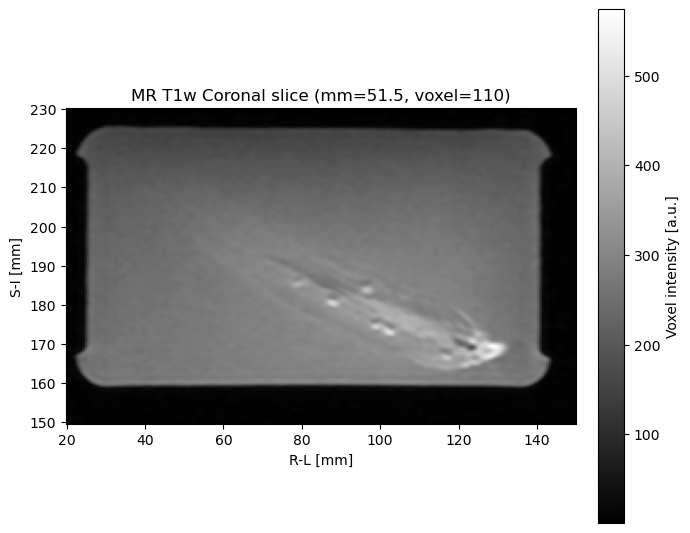

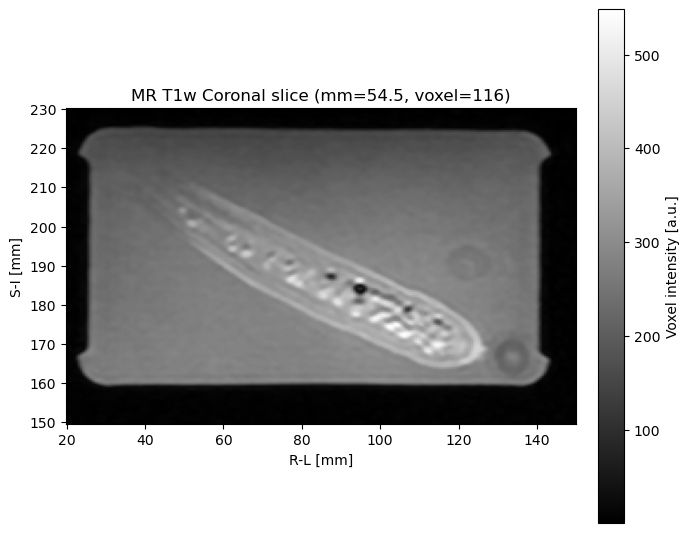

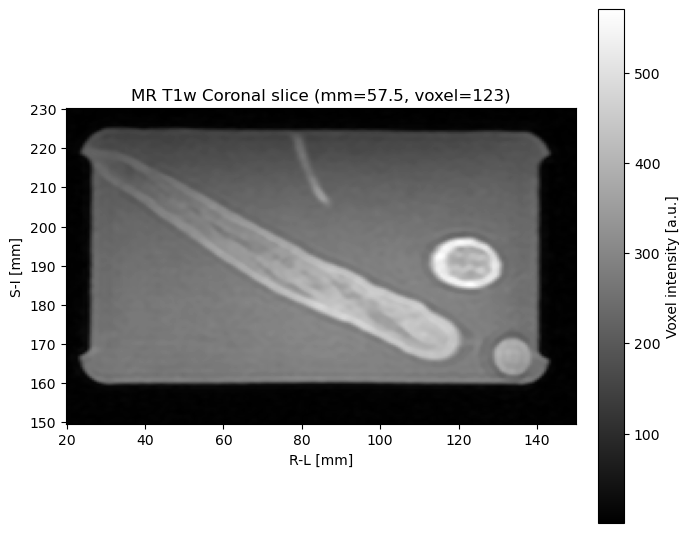

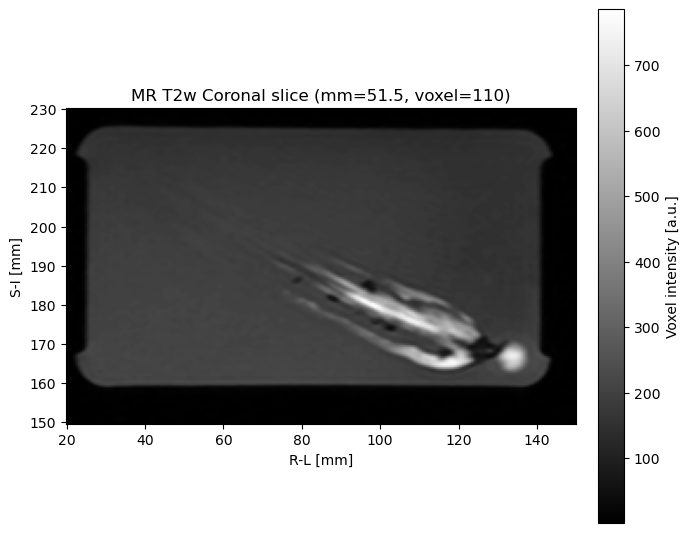

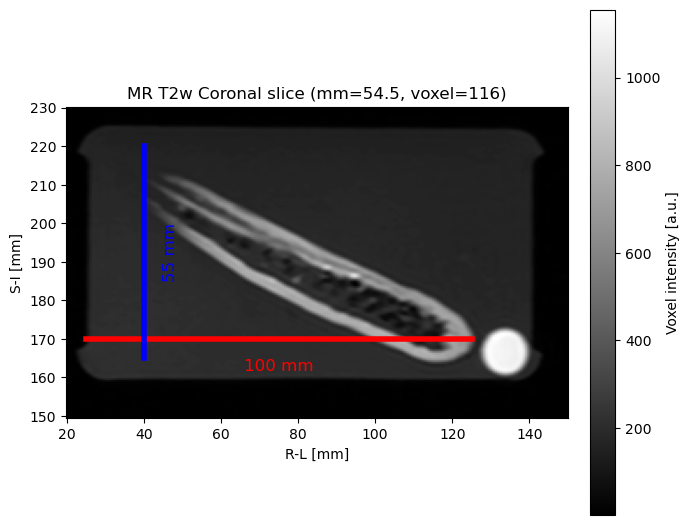

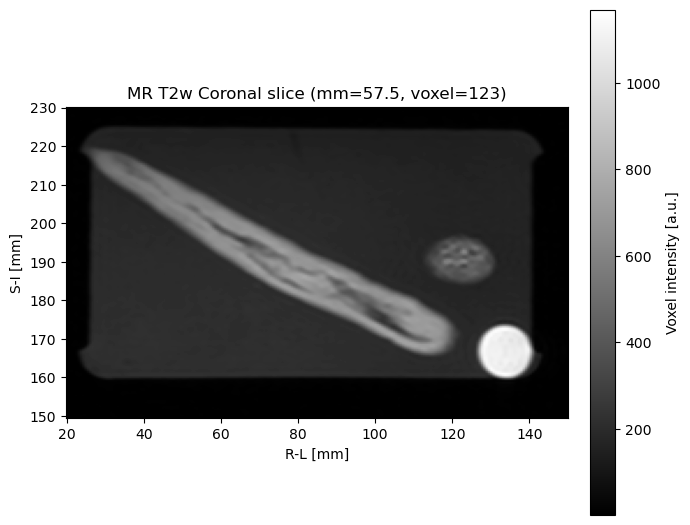

In [ ]:
AP_mm  = (35, 85)
RL_mm  = (20, 150)
SI_mm  = (150, 230)

Object1SliceSearch = 51.5

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object1SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T1w_Coronal1.svg"
)

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object1SliceSearch+3,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T1w_Coronal2.svg"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object1SliceSearch+6,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T1w_Coronal3.svg"
)

# ==========================
# Repeat for T2
# ==========================

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object1SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T2w_Coronal1.svg"
)

show_slice_with_scalebars(
    t2w_img3d, t2w_voxel,
    slice_mm=Object1SliceSearch+3,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    h_scalebar_mm=100,
    v_scalebar_mm=55,
    h_scalebar_pos_mm=(25+100/2, 170),  # horizontal scalebar at x=50 mm, y=180 mm
    v_scalebar_pos_mm=(40, 165+27.5), # vertical scalebar at x=100 mm, y=200 mm
    h_scalebar_color='red',
    v_scalebar_color='blue',
    # save_svg=True,
    # svg_filename="MRI_Chilli_T2w_Coronal2.svg"
)

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object1SliceSearch+6,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T2w_Coronal3.svg"
)

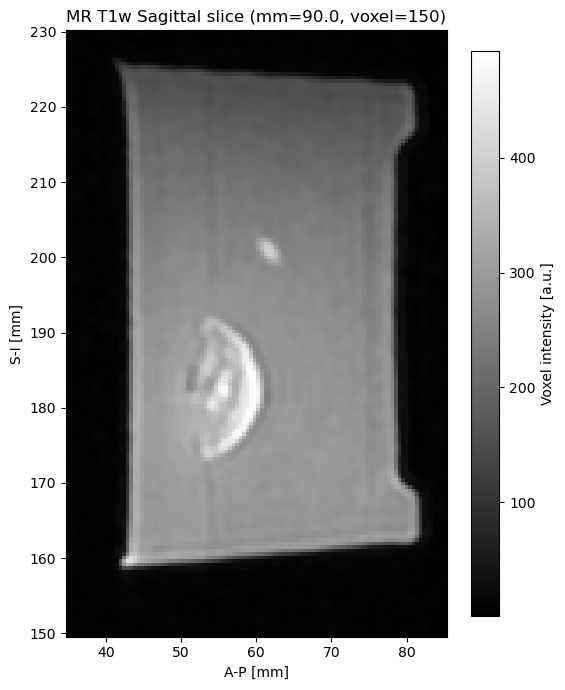

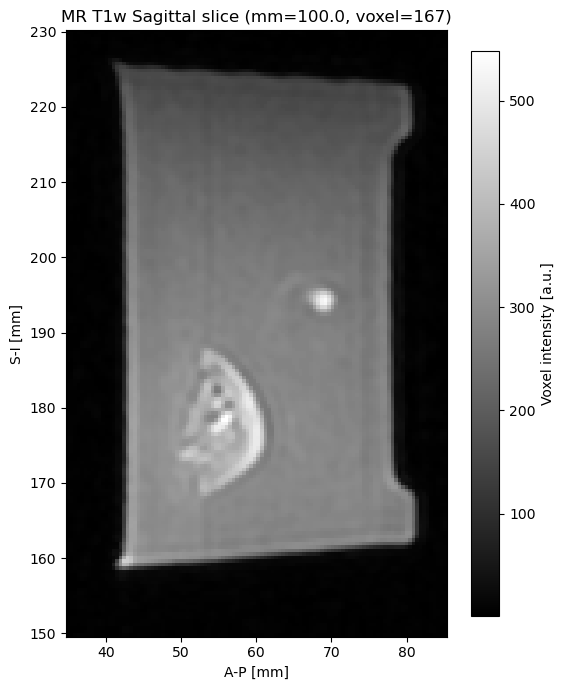

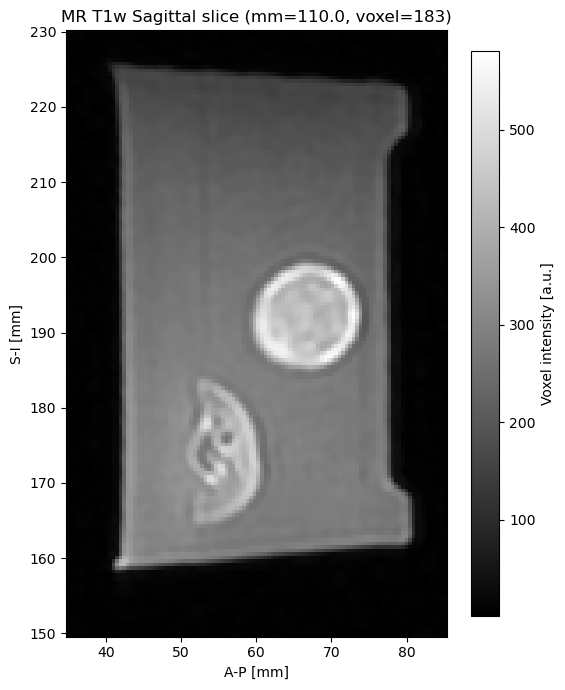

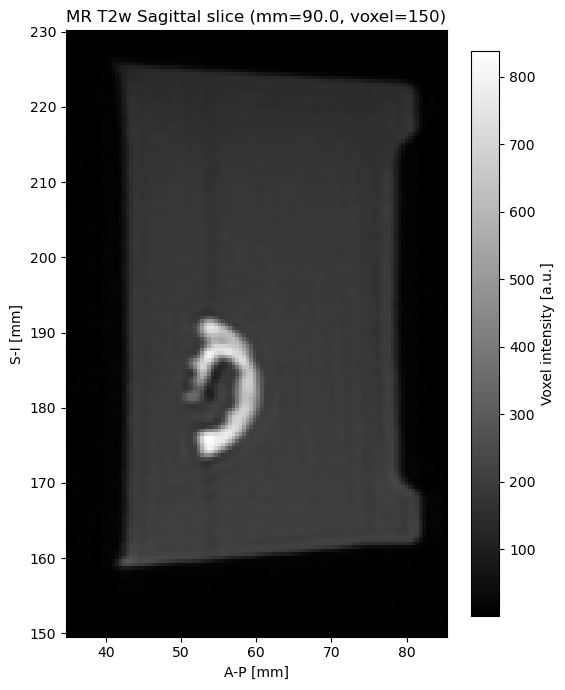

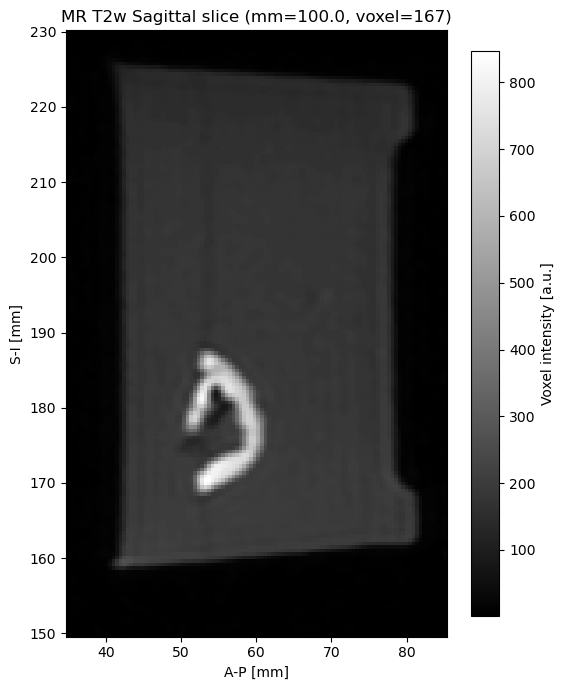

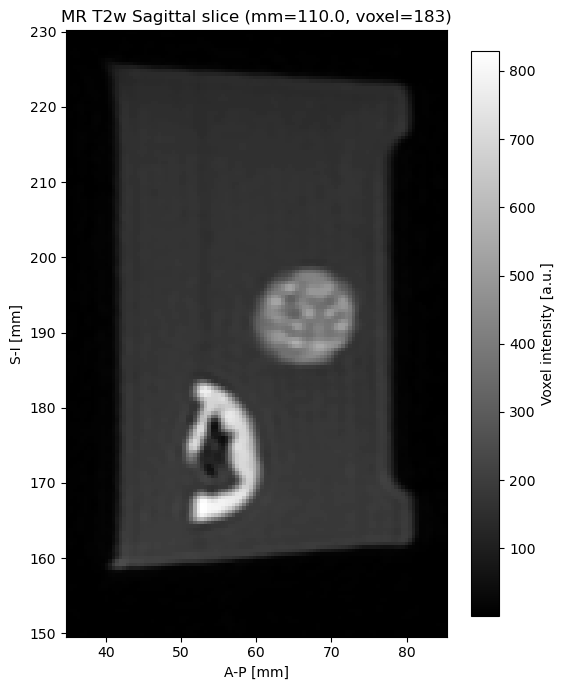

In [ ]:
# Saggital view

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=90,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T1w_Sagittal1.svg"
)

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=100,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T1w_Sagittal2.svg"
)

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=110,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T1w_Sagittal3.svg"
)

#########
# T2w
#########

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=90,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T2w_Sagittal1.svg"
)

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=100,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T2w_Sagittal2.svg"
)

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=110,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T2w_Sagittal3.svg"
)

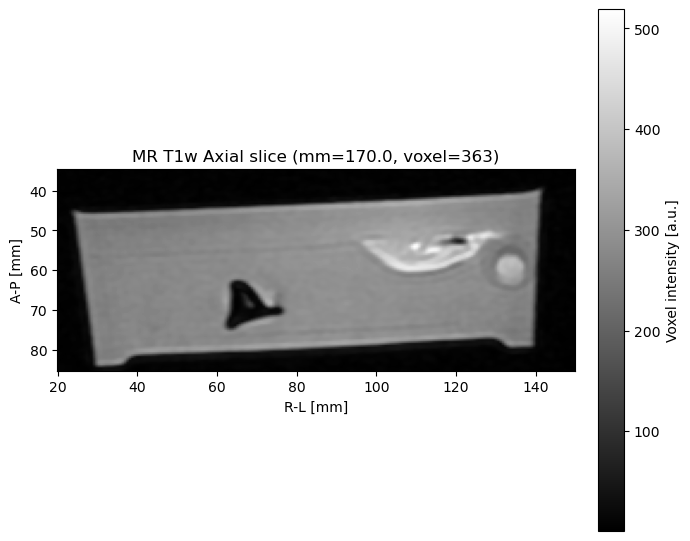

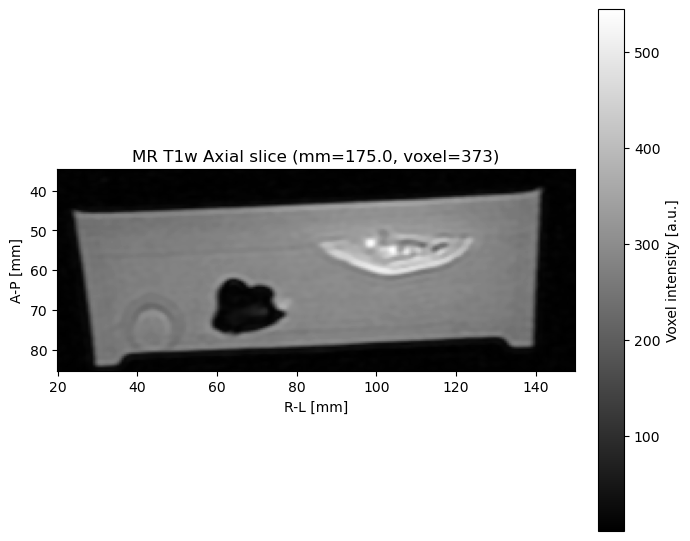

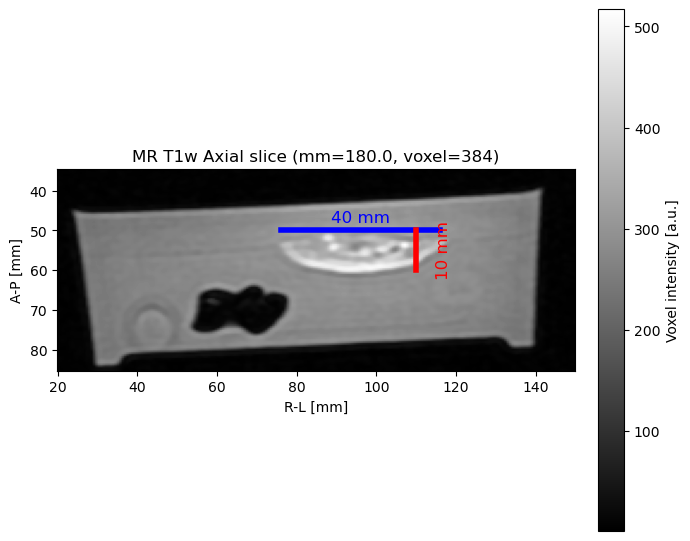

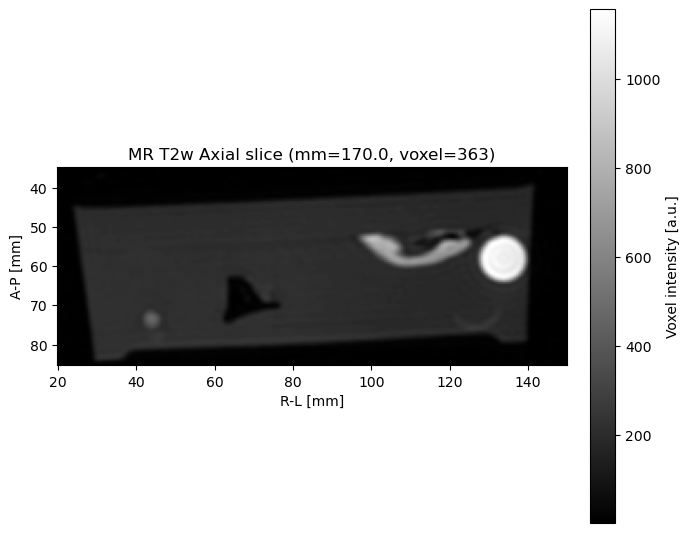

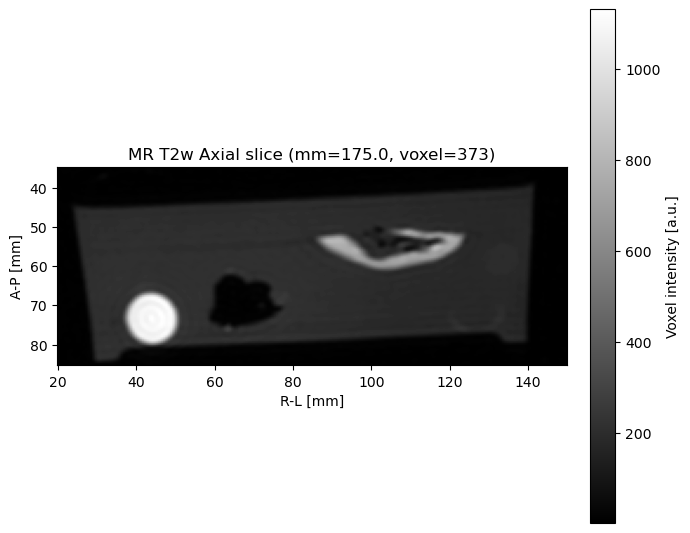

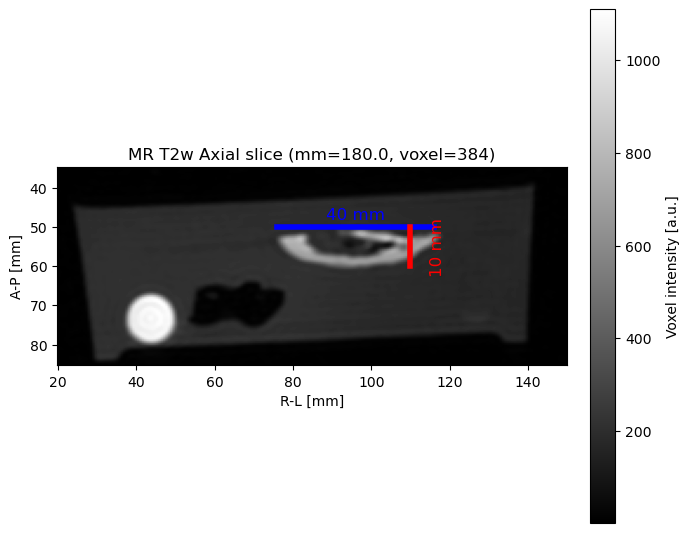

In [28]:
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=170,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T1w_Axial1.svg"
)

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=175,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T1w_Axial2.svg"
)

show_slice_with_scalebars(
    t1w_img3d, t1w_voxel,
    slice_mm=180,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    h_scalebar_mm=40,
    v_scalebar_mm=10,
    h_scalebar_pos_mm=(76+40/2, 50),  # horizontal scalebar at x=50 mm, y=180 mm
    v_scalebar_pos_mm=(110, 50+10/2), # vertical scalebar at x=100 mm, y=200 mm
    h_scalebar_color='blue',
    v_scalebar_color='red',
    # save_svg=True,
    # svg_filename="MRI_Chilli_T1w_Axial3.svg"
)

#######
# T2w
#######

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=170,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T2w_Axial1.svg"
)

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=175,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Chilli_T2w_Axial2.svg"
)

show_slice_with_scalebars(
    t2w_img3d, t2w_voxel,
    slice_mm=180,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    h_scalebar_mm=40,
    v_scalebar_mm=10,
    h_scalebar_pos_mm=(76+40/2, 50),  # horizontal scalebar at x=50 mm, y=180 mm
    v_scalebar_pos_mm=(110, 50+10/2), # vertical scalebar at x=100 mm, y=200 mm
    h_scalebar_color='blue',
    v_scalebar_color='red',
    # save_svg=True,
    # svg_filename="MRI_Chilli_T2w_Axial3.svg"
)

## Object 2

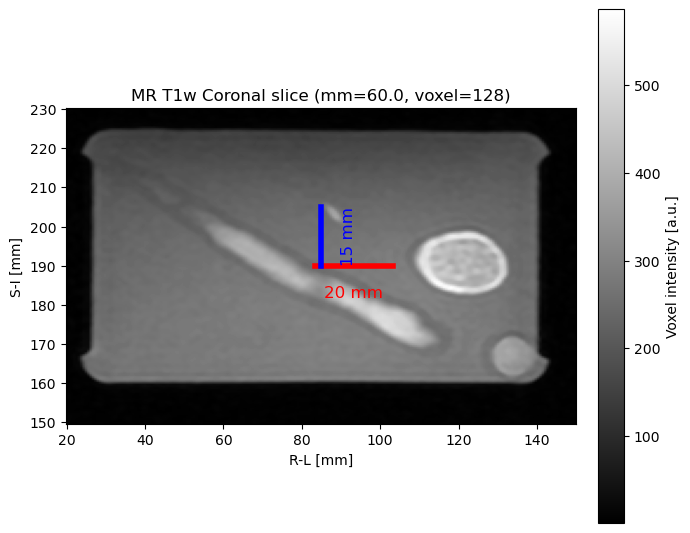

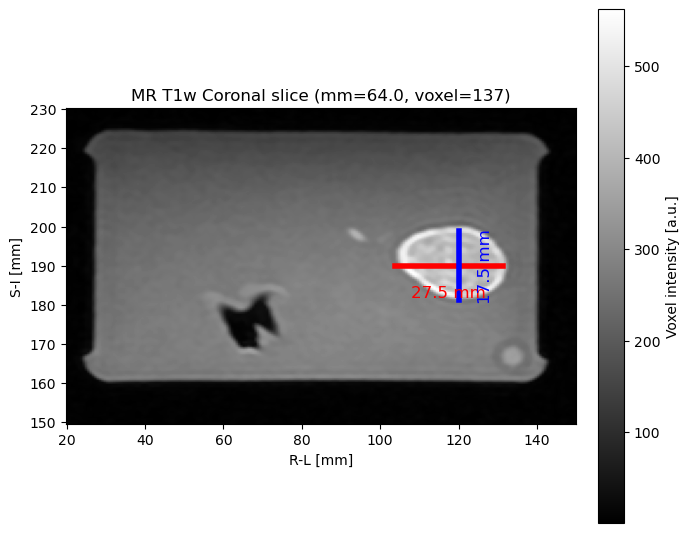

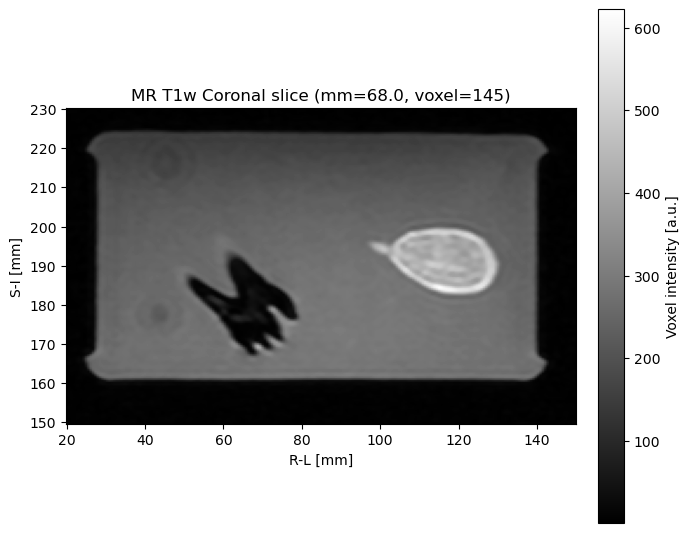

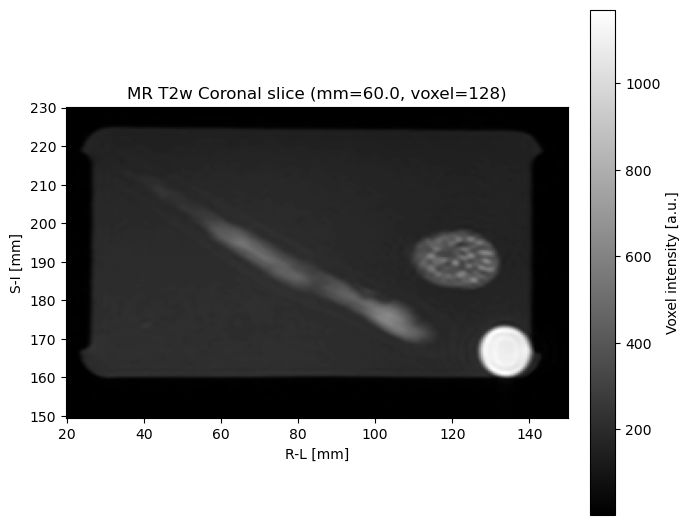

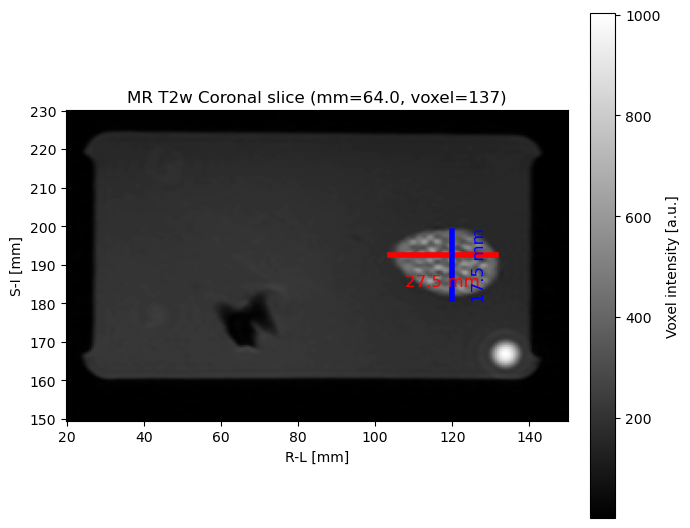

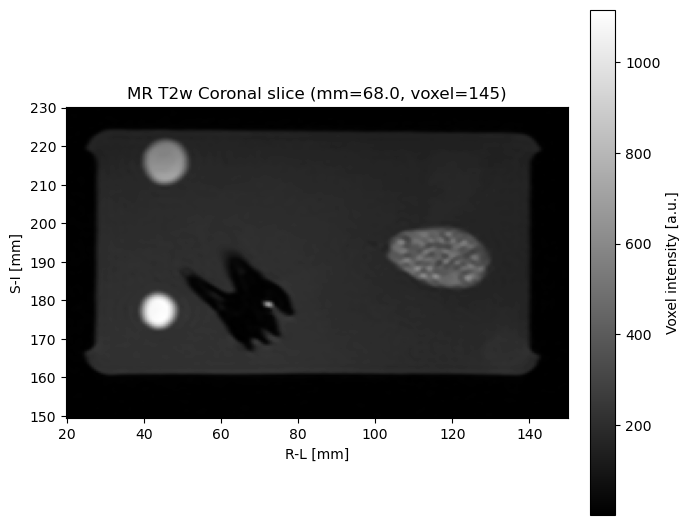

In [ ]:
Object2SliceSearch = 60

show_slice_with_scalebars(
    t1w_img3d, t1w_voxel,
    slice_mm=Object2SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    h_scalebar_mm=20,
    v_scalebar_mm=15,
    h_scalebar_pos_mm=(82+22.5/2, 190),  # horizontal scalebar at x=50 mm, y=180 mm
    v_scalebar_pos_mm=(85, 190+15/2), # vertical scalebar at x=100 mm, y=200 mm
    h_scalebar_color='red',
    v_scalebar_color='blue',
    # save_svg=True,
    # svg_filename="MRI_Fig_T1w_Coronal1.svg"
)

show_slice_with_scalebars(
    t1w_img3d, t1w_voxel,
    slice_mm=Object2SliceSearch+4,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    h_scalebar_mm=27.5,
    v_scalebar_mm=17.5,
    h_scalebar_pos_mm=(102.5+30/2, 190),  # horizontal scalebar at x=50 mm, y=180 mm
    v_scalebar_pos_mm=(120, 180+20/2), # vertical scalebar at x=100 mm, y=200 mm
    h_scalebar_color='red',
    v_scalebar_color='blue',
    # save_svg=True,
    # svg_filename="MRI_Fig_T1w_Coronal2.svg"
)

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object2SliceSearch+8,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Fig_T1w_Coronal3.svg"
)

# ==========================
# Repeat for T2
# ==========================

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object2SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Fig_T2w_Coronal1.svg"
)

show_slice_with_scalebars(
    t2w_img3d, t2w_voxel,
    slice_mm=Object2SliceSearch+4,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    h_scalebar_mm=27.5,
    v_scalebar_mm=17.5,
    h_scalebar_pos_mm=(102.5+30/2, 192.5),  # horizontal scalebar at x=50 mm, y=180 mm
    v_scalebar_pos_mm=(120, 180+20/2), # vertical scalebar at x=100 mm, y=200 mm
    h_scalebar_color='red',
    v_scalebar_color='blue',
    # save_svg=True,
    # svg_filename="MRI_Fig_T2w_Coronal2.svg"
)

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object2SliceSearch+8,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Fig_T2w_Coronal3.svg"
)

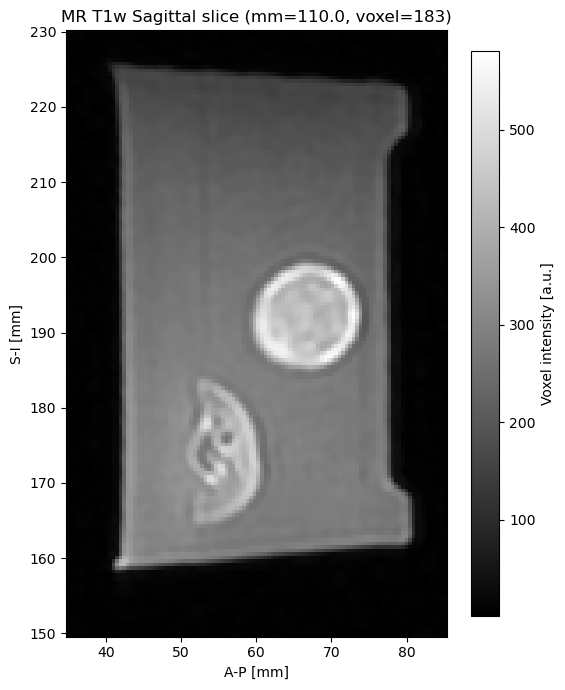

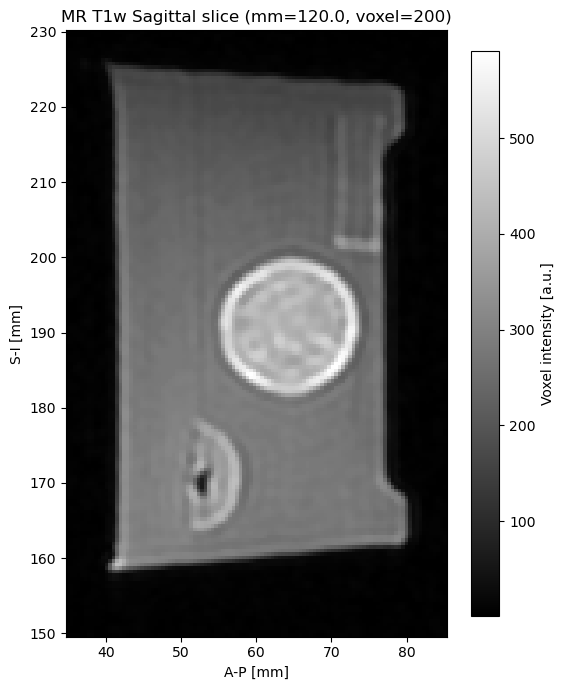

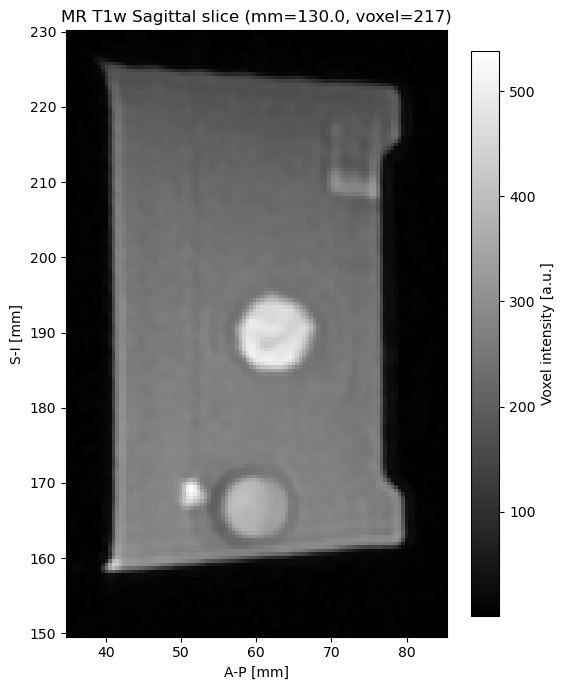

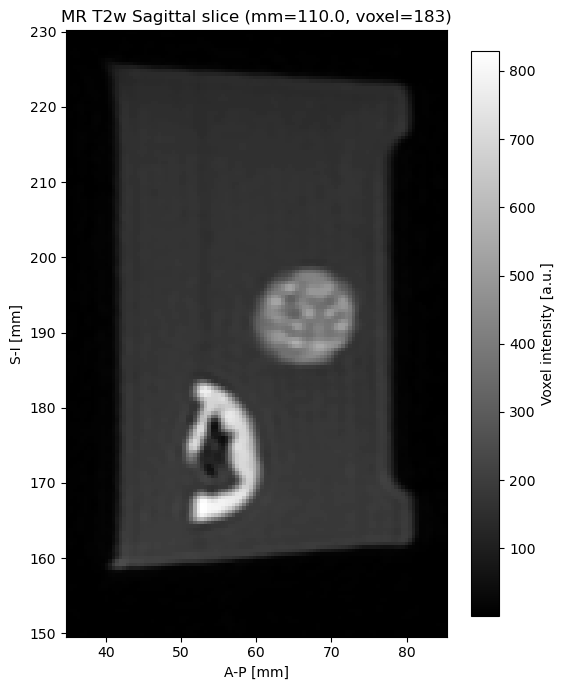

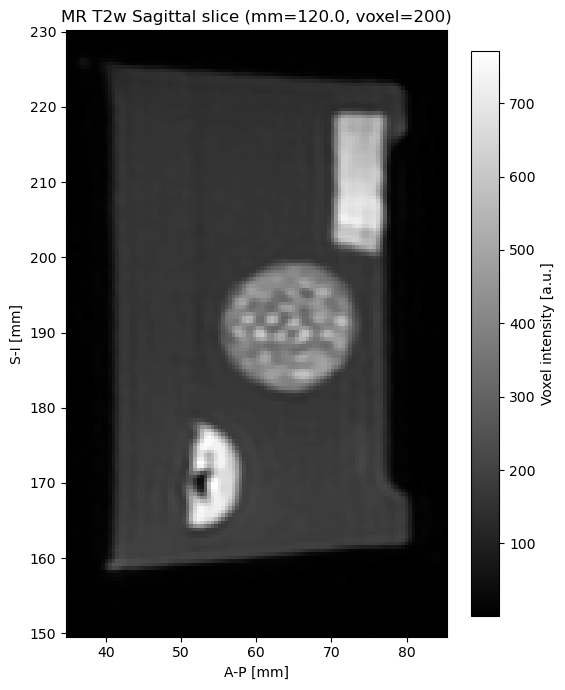

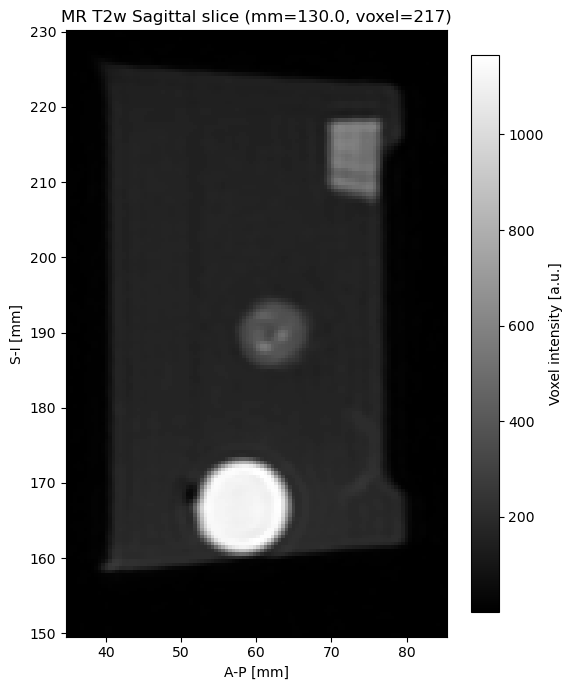

In [ ]:
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=110,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Fig_T1w_Sagittal1.svg"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=120,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Fig_T1w_Sagittal2.svg"
)

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=130,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Fig_T1w_Sagittal3.svg"
)

#########
# T2w
#########

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=110,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Fig_T2w_Sagittal1.svg"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=120,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Fig_T2w_Sagittal2.svg"
)

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=130,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Fig_T2w_Sagittal3.svg"
)

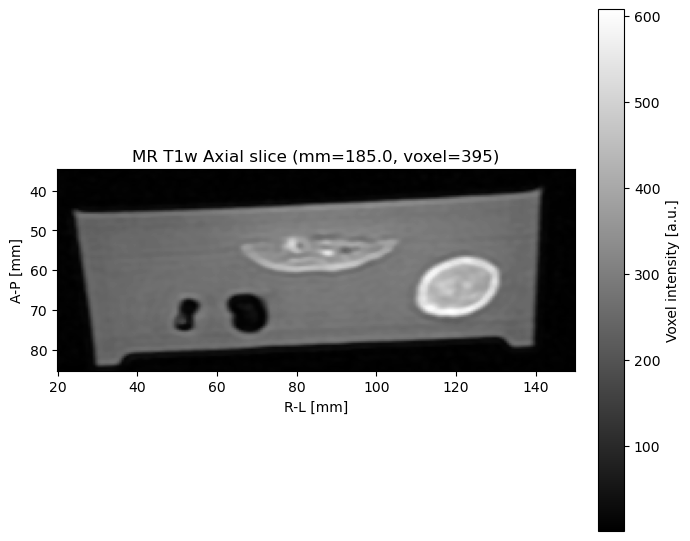

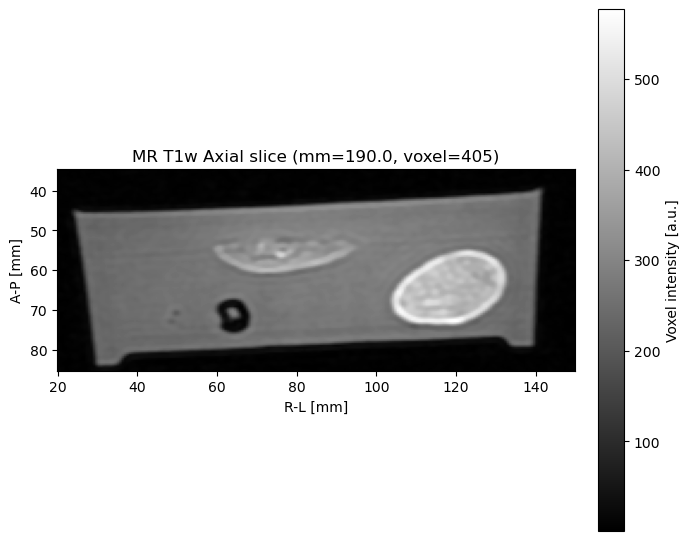

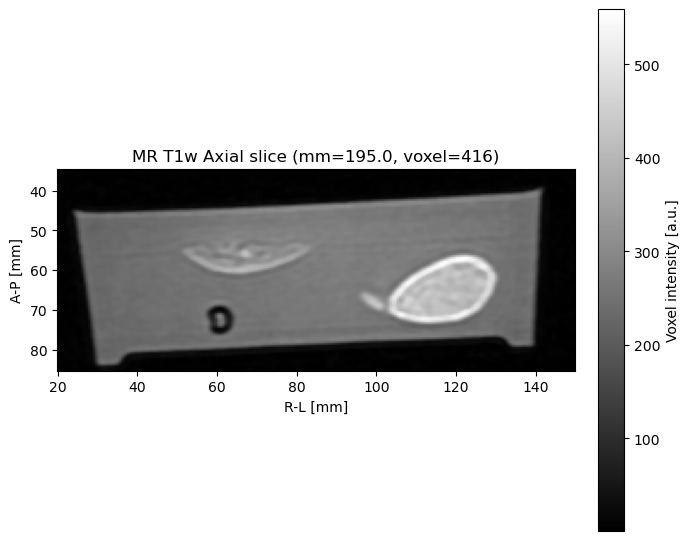

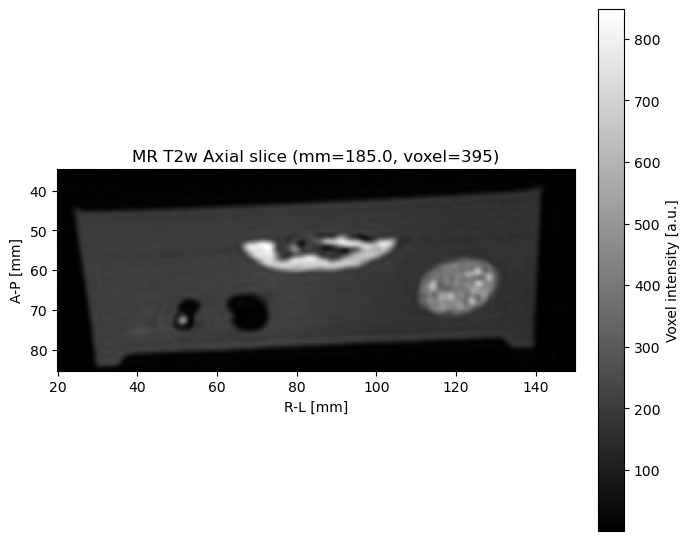

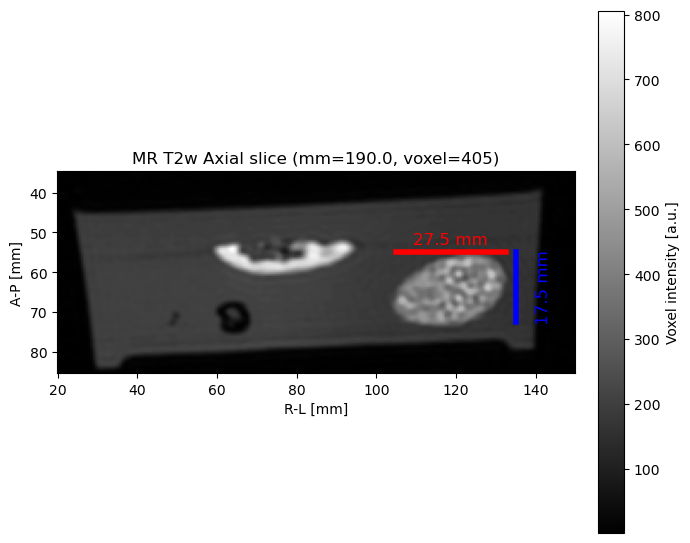

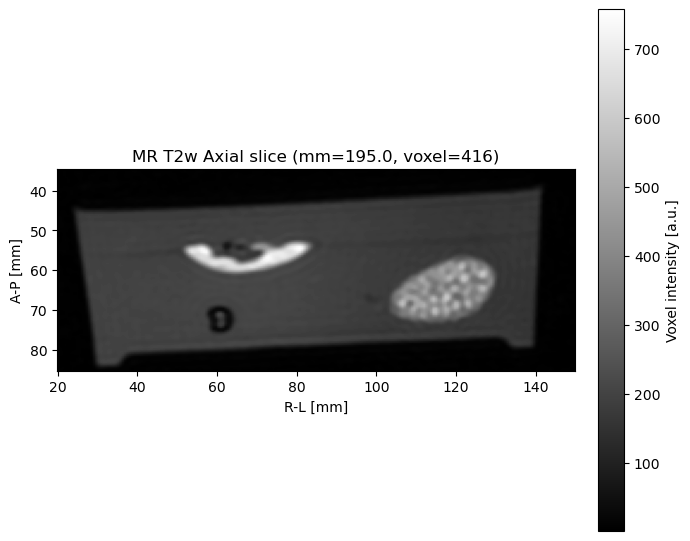

In [ ]:
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=185,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Fig_T1w_Axial1.svg"
)

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=190,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Fig_T1w_Axial2.svg"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=195,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Fig_T1w_Axial3.svg"
)

########
#T2w
########

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=185,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Fig_T2w_Axial1.svg"
)
show_slice_with_scalebars(
    t2w_img3d, t2w_voxel,
    slice_mm=190,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    h_scalebar_mm=27.5,
    v_scalebar_mm=17.5,
    h_scalebar_pos_mm=(105+27.5/2, 55),  # horizontal scalebar at x=50 mm, y=180 mm
    v_scalebar_pos_mm=(135, 55+17.5/2), # vertical scalebar at x=100 mm, y=200 mm
    h_scalebar_color='red',
    v_scalebar_color='blue',
    # save_svg=True,
    # svg_filename="MRI_Fig_T2w_Axial2.svg"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=195,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Fig_T2w_Axial3.svg"
)

## Object 3

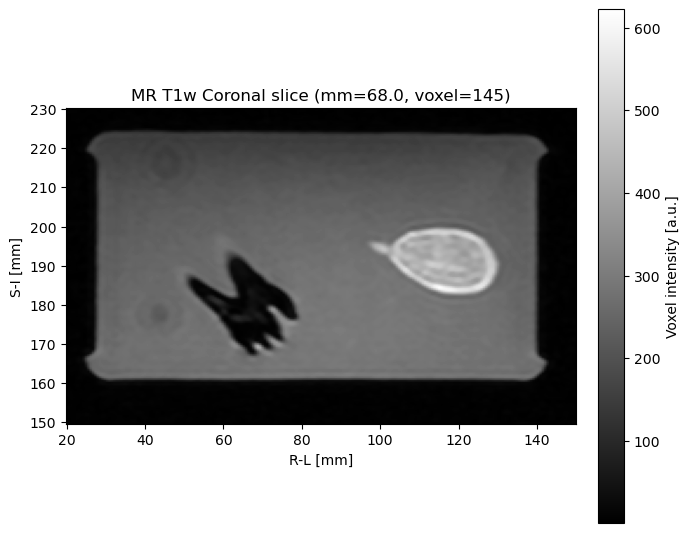

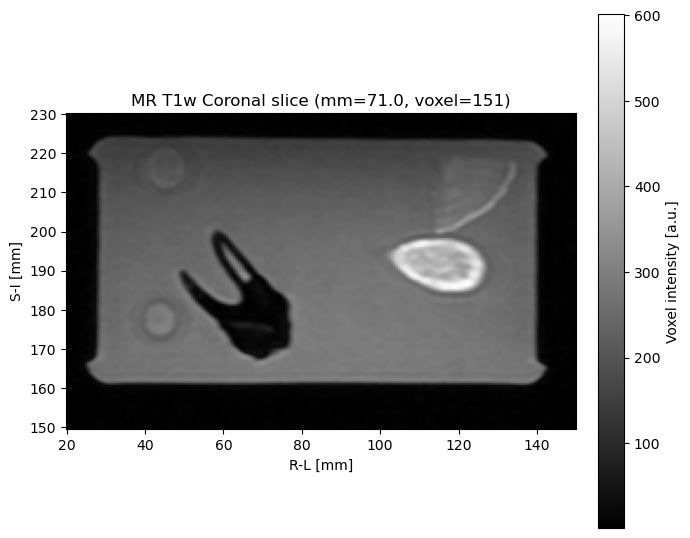

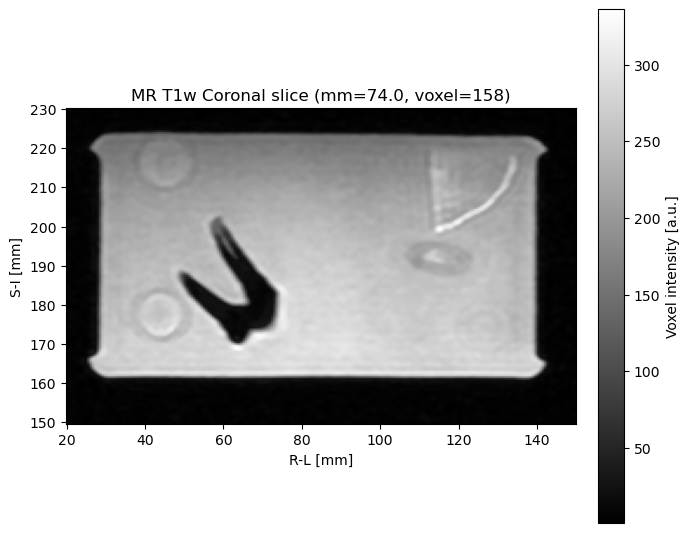

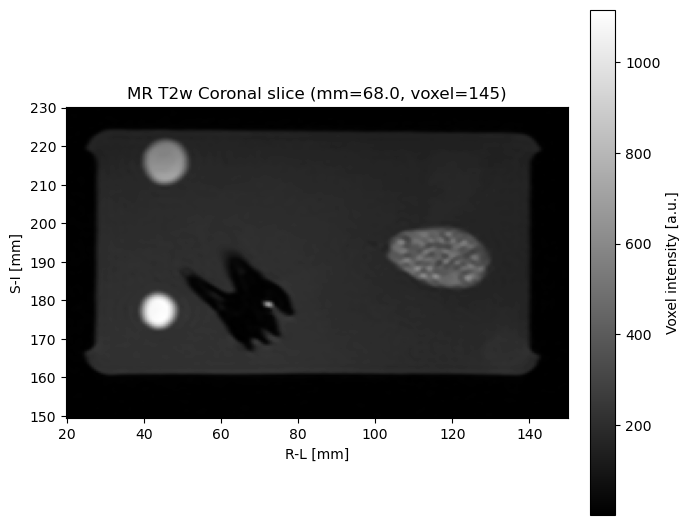

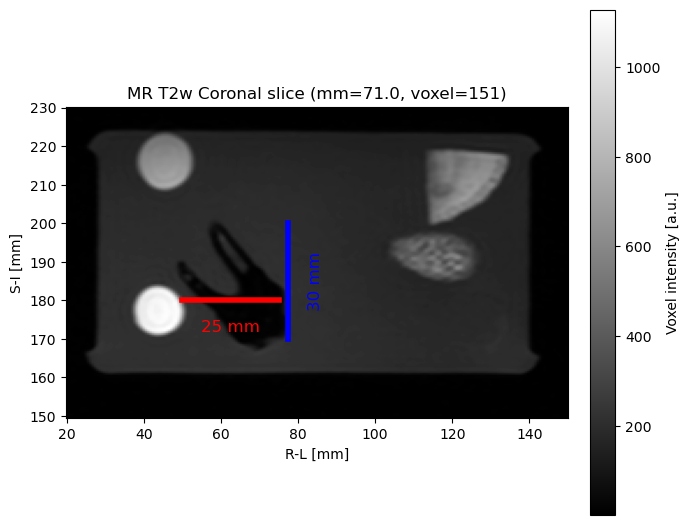

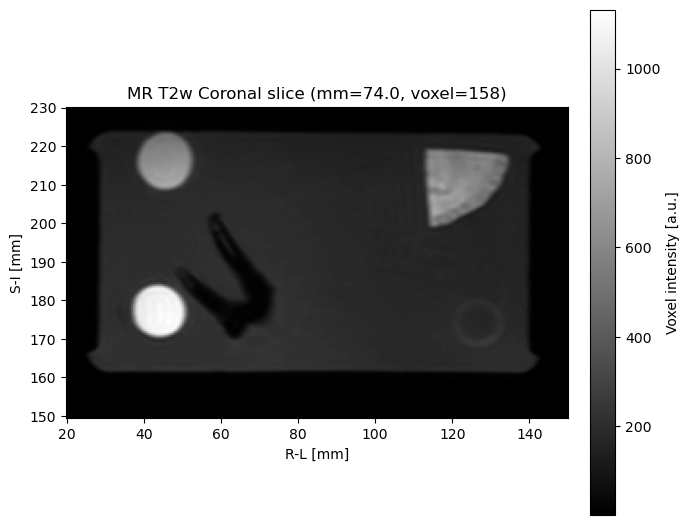

In [ ]:
Object3SliceSearch = 68

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object3SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T1w_Coronal1.svg"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object3SliceSearch+3,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T1w_Coronal2.svg"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object3SliceSearch+6,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T1w_Coronal3.svg"
)

# ==========================
# Repeat for T2
# ==========================

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object3SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T2w_Coronal1.svg"
)

show_slice_with_scalebars(
    t2w_img3d, t2w_voxel,
    slice_mm=Object3SliceSearch+3,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    h_scalebar_mm=25,
    v_scalebar_mm=30,
    h_scalebar_pos_mm=(50+25/2, 180),  # horizontal scalebar at x=50 mm, y=180 mm
    v_scalebar_pos_mm=(77.5, 170+30/2), # vertical scalebar at x=100 mm, y=200 mm
    h_scalebar_color='red',
    v_scalebar_color='blue',
    # save_svg=True,
    # svg_filename="MRI_Tooth_T2w_Coronal2.svg"
)

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object3SliceSearch+6,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T2w_Coronal3.svg"
)

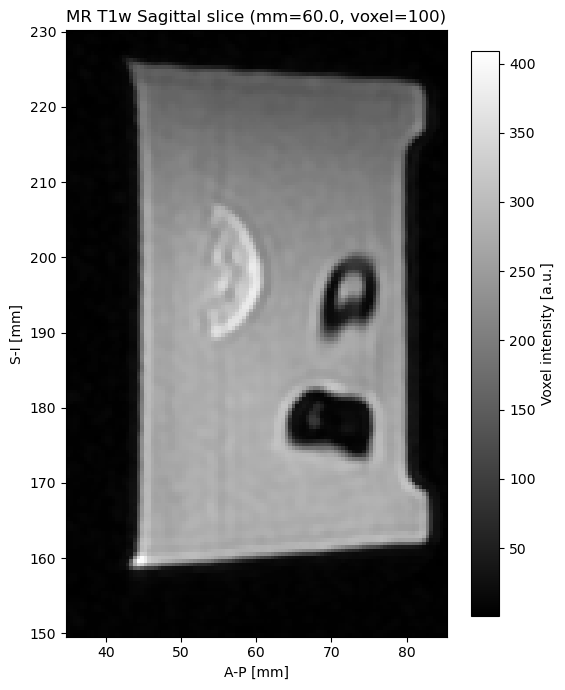

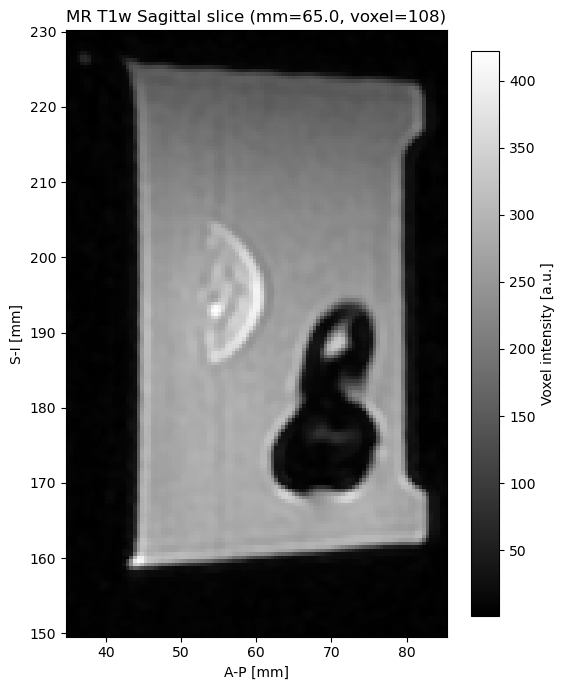

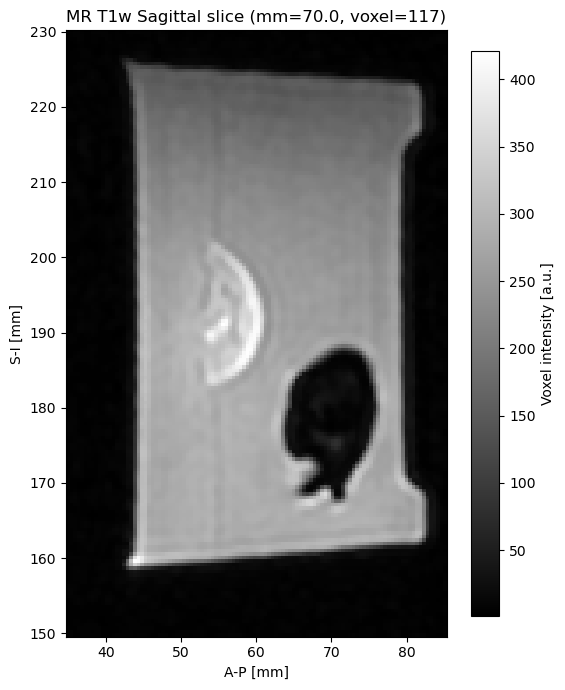

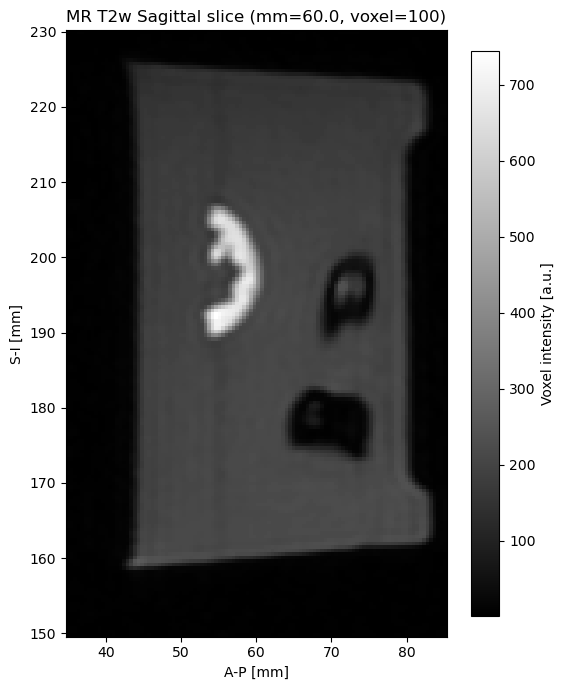

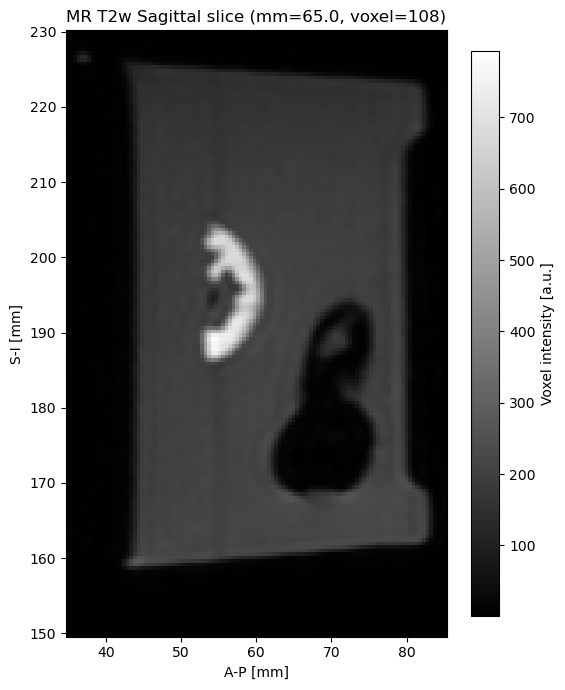

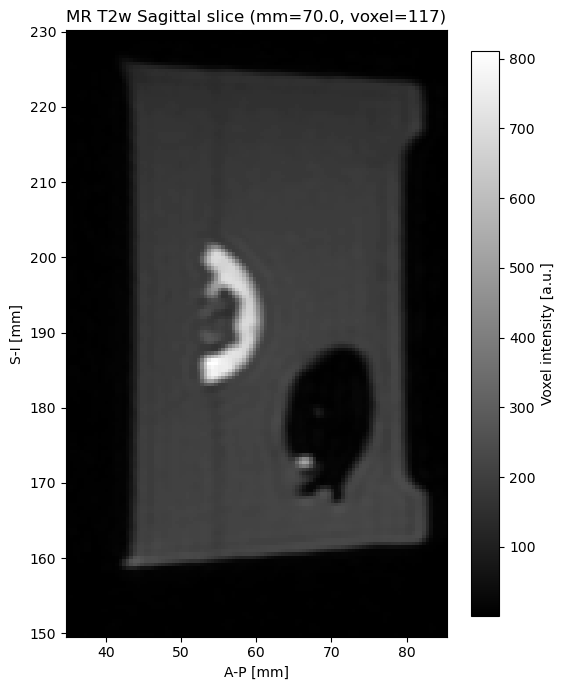

In [ ]:
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=60,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T1w_Sagittal1.svg"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=65,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T1w_Sagittal2.svg"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=70,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T1w_Sagittal3.svg"
)

######
# T2w
######

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=60,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T2w_Sagittal1.svg"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=65,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T2w_Sagittal2.svg"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=70,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T2w_Sagittal3.svg"
)

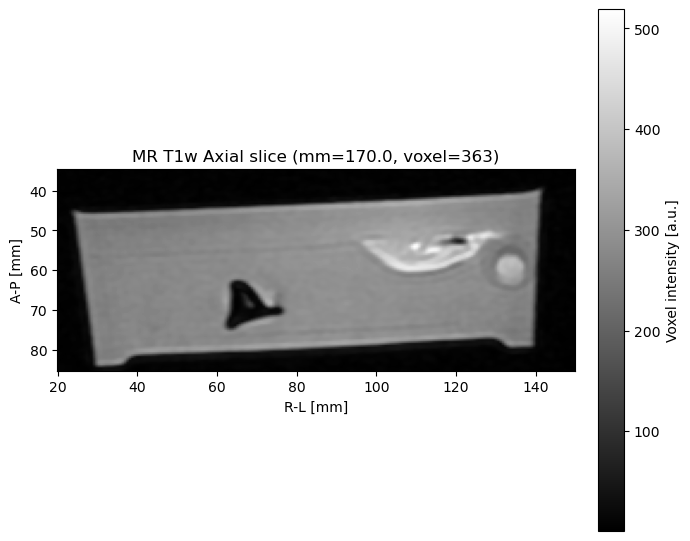

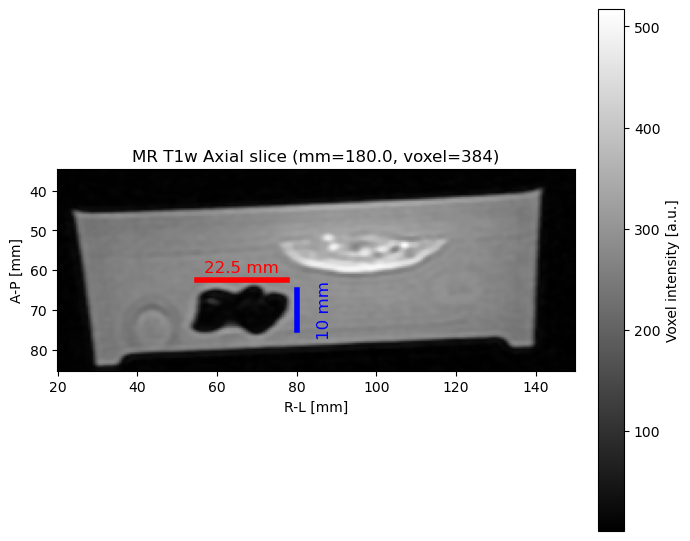

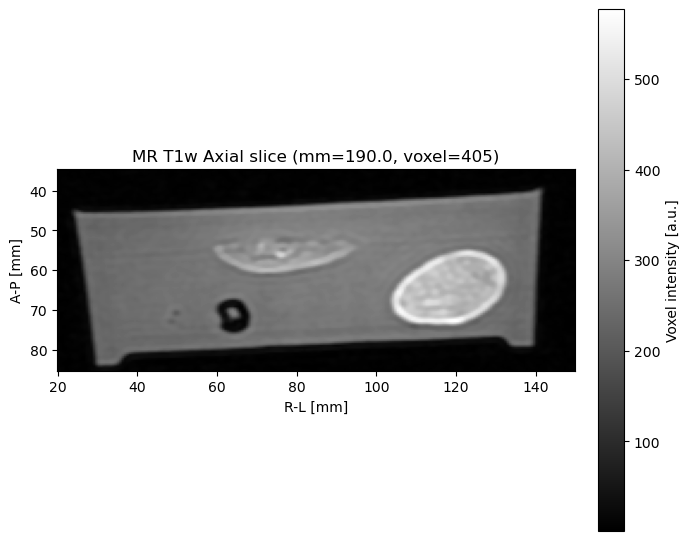

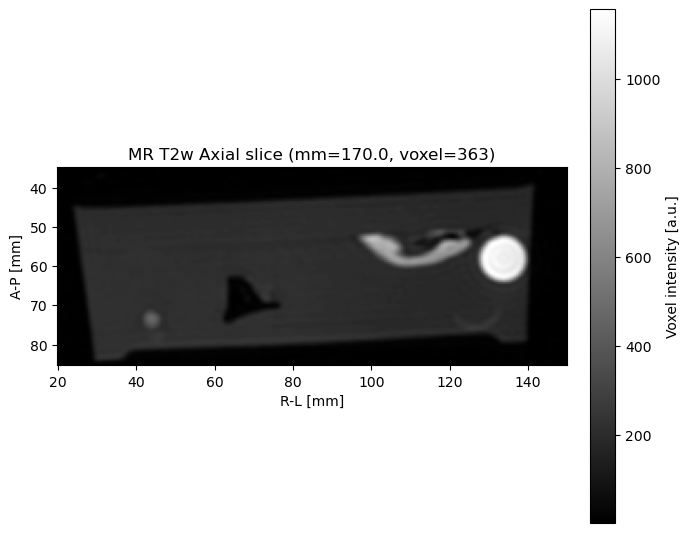

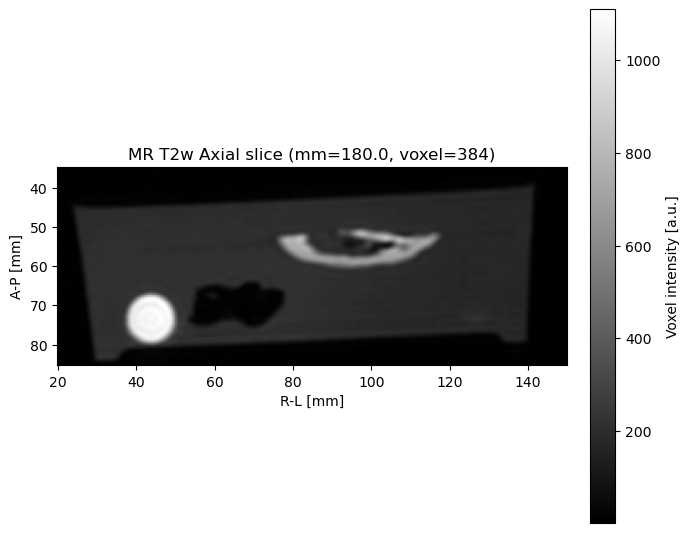

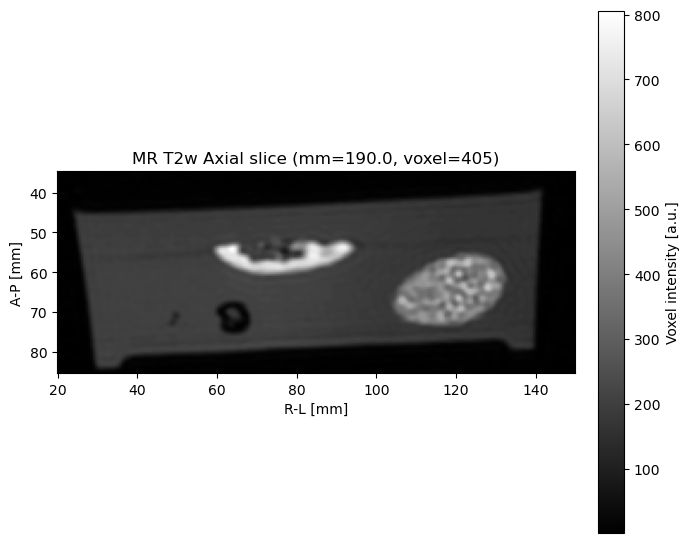

In [ ]:
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=170,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T1w_Axial1.svg"
)

show_slice_with_scalebars(
    t1w_img3d, t1w_voxel,
    slice_mm=180,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    h_scalebar_mm=22.5,
    v_scalebar_mm=10,
    h_scalebar_pos_mm=(55+22.5/2, 62.5),  # horizontal scalebar at x=50 mm, y=180 mm
    v_scalebar_pos_mm=(80, 65+10/2), # vertical scalebar at x=100 mm, y=200 mm
    h_scalebar_color='red',
    v_scalebar_color='blue',
    # save_svg=True,
    # svg_filename="MRI_Tooth_T1w_Axial2.svg"
)

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=190,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T1w_Axial3.svg"
)

########
# T2w
########

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=170,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T2w_Axial1.svg"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=180,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T2w_Axial2.svg"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=190,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Tooth_T2w_Axial3.svg"
)

## Object 4

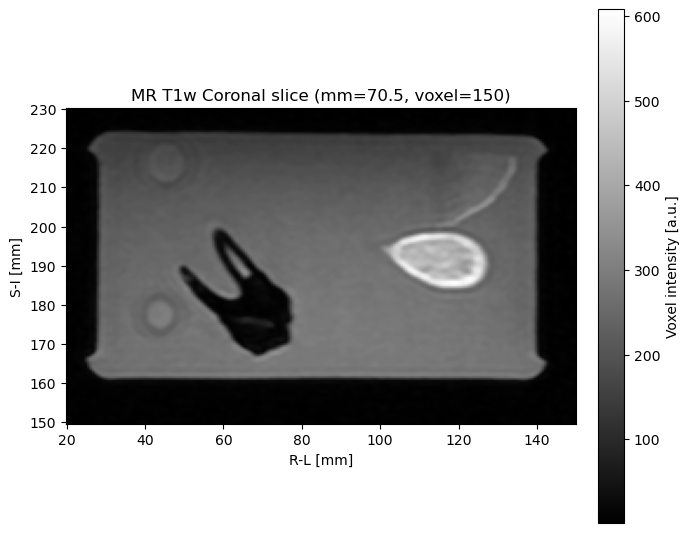

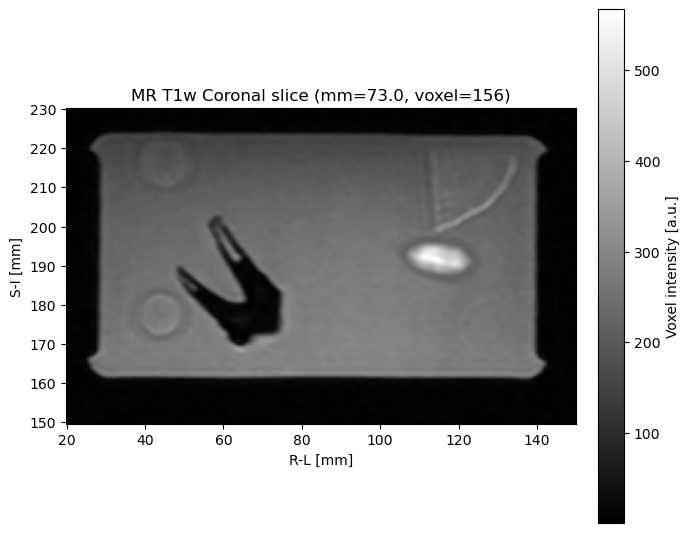

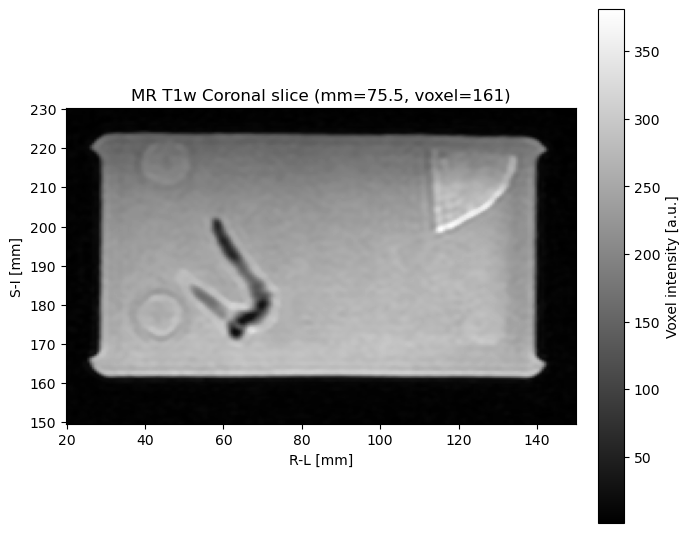

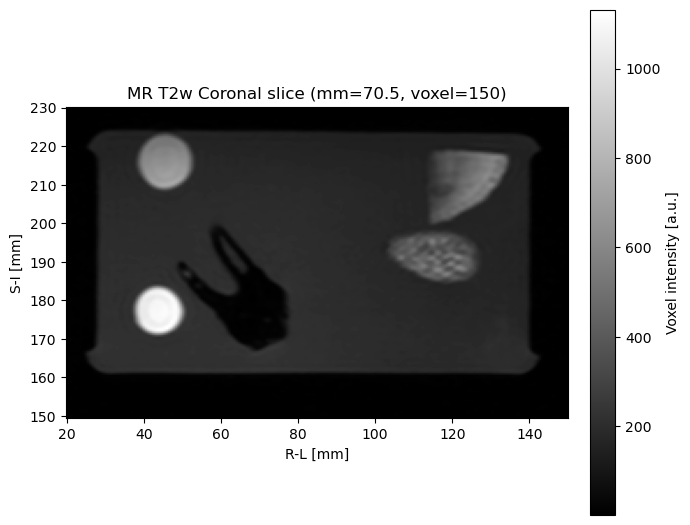

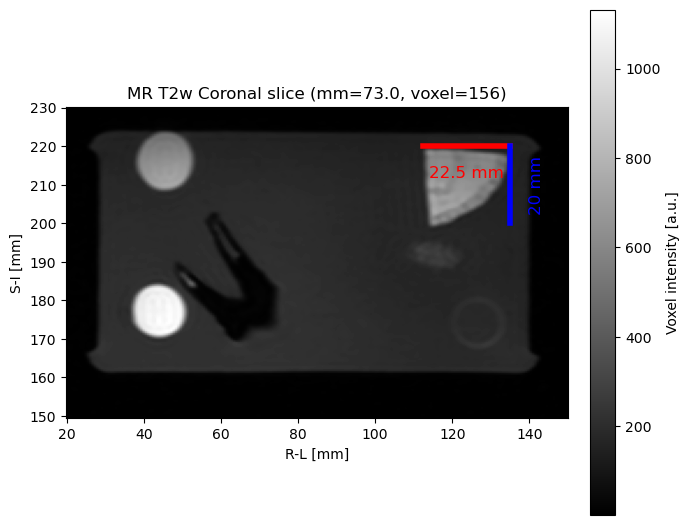

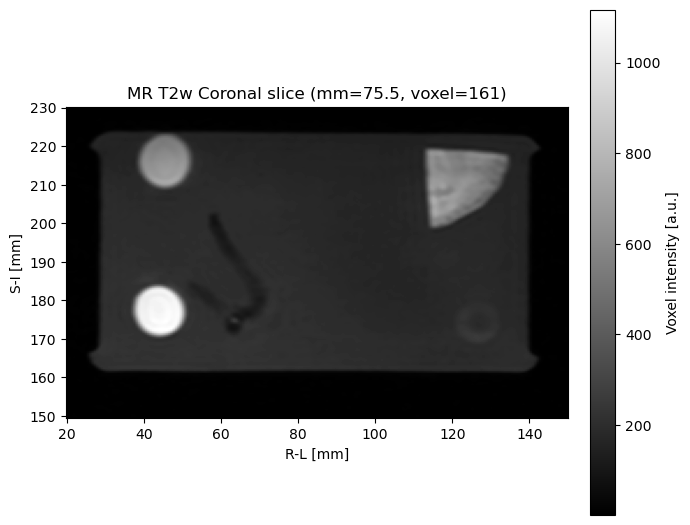

In [ ]:
Object4SliceSearch = 70.5

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object4SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T1w_Coronal1.svg"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object4SliceSearch+2.5,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T1w_Coronal2.svg"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object4SliceSearch+5,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T1w_Coronal3.svg"
)

#######
# T2w
#######

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object4SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T2w_Coronal1.svg"
)

show_slice_with_scalebars(
    t2w_img3d, t2w_voxel,
    slice_mm=Object4SliceSearch+2.5,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    h_scalebar_mm=22.5,
    v_scalebar_mm=20,
    h_scalebar_pos_mm=(112.5+22.5/2, 220),  # horizontal scalebar at x=50 mm, y=180 mm
    v_scalebar_pos_mm=(135, 200+20/2), # vertical scalebar at x=100 mm, y=200 mm
    h_scalebar_color='red',
    v_scalebar_color='blue',
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T2w_Coronal2.svg"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object4SliceSearch+5,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T2w_Coronal3.svg"
)

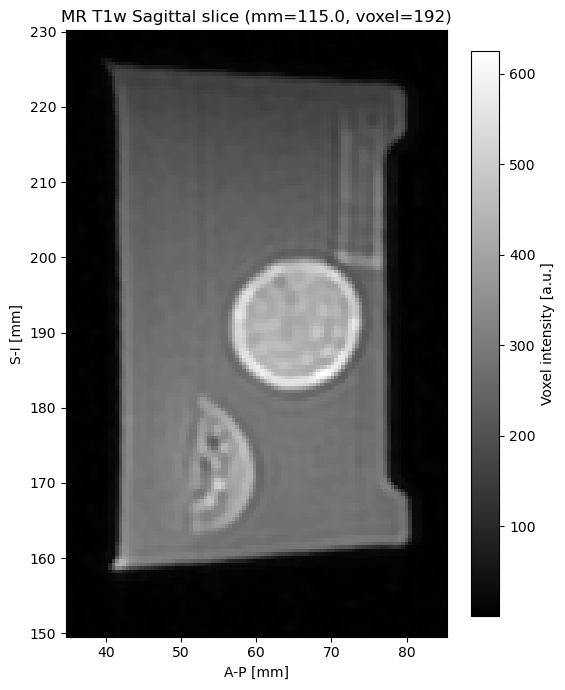

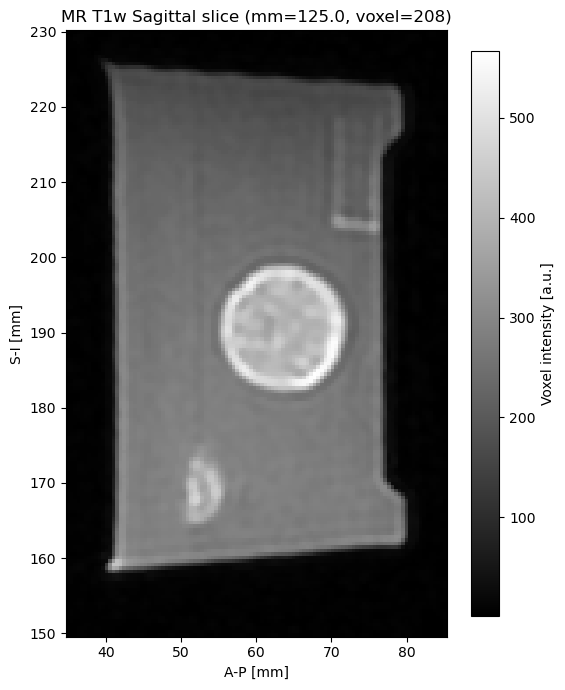

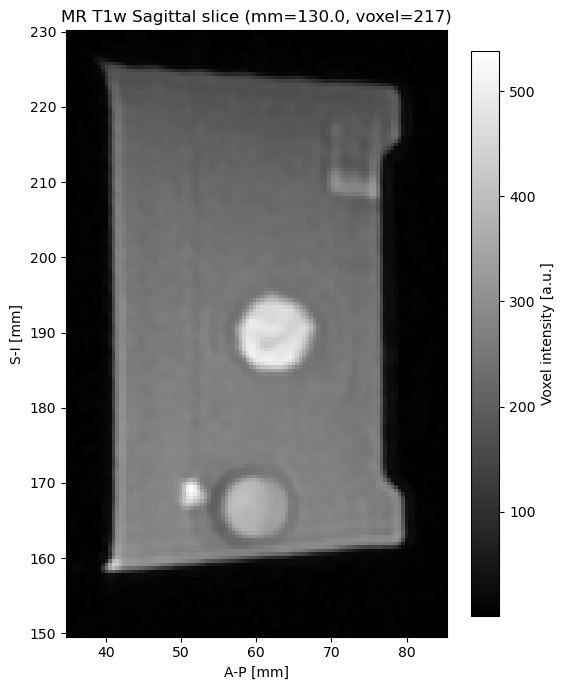

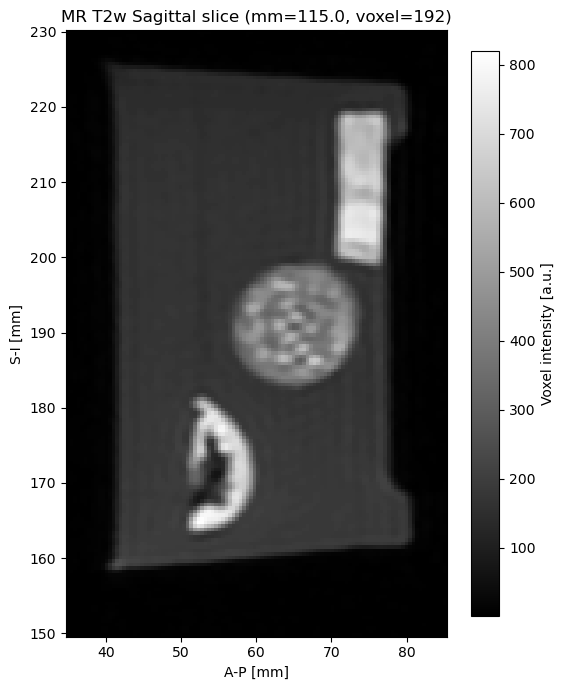

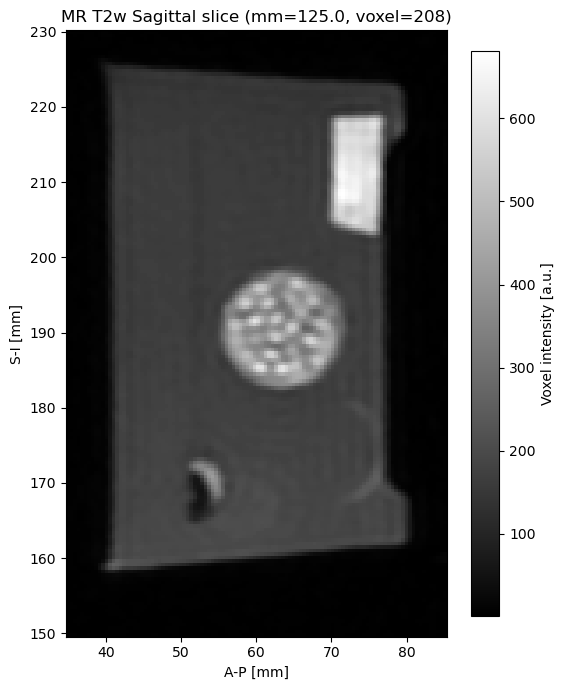

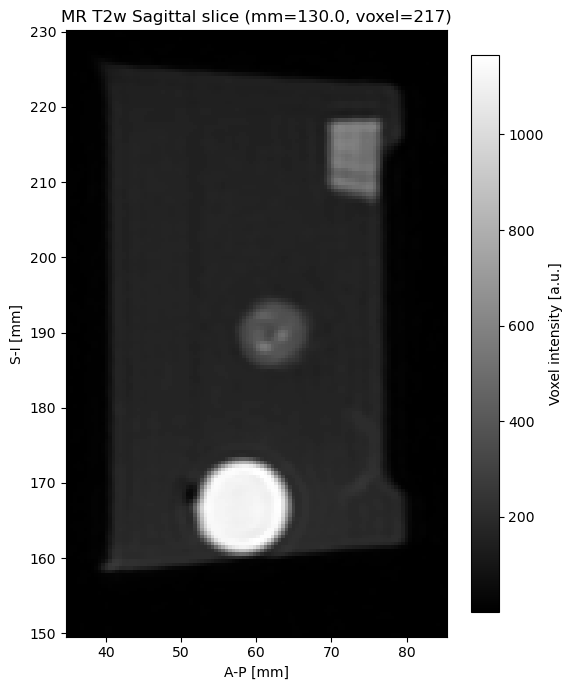

In [ ]:
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=115,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T1w_Sagittal1.svg"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=125,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T1w_Sagittal2.svg"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=130,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T1w_Sagittal3.svg"
)

######
# T2w
######

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=115,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T2w_Sagittal1.svg"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=125,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T2w_Sagittal2.svg"
)

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=130,
    orientation="sagittal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T2w_Sagittal3.svg"
)

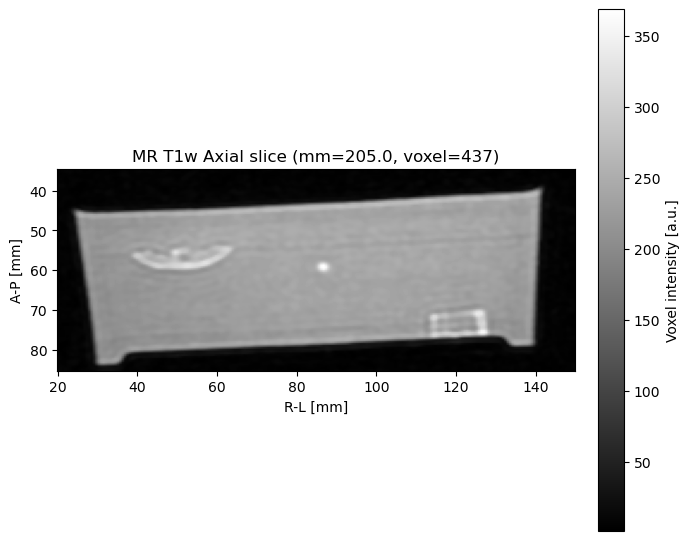

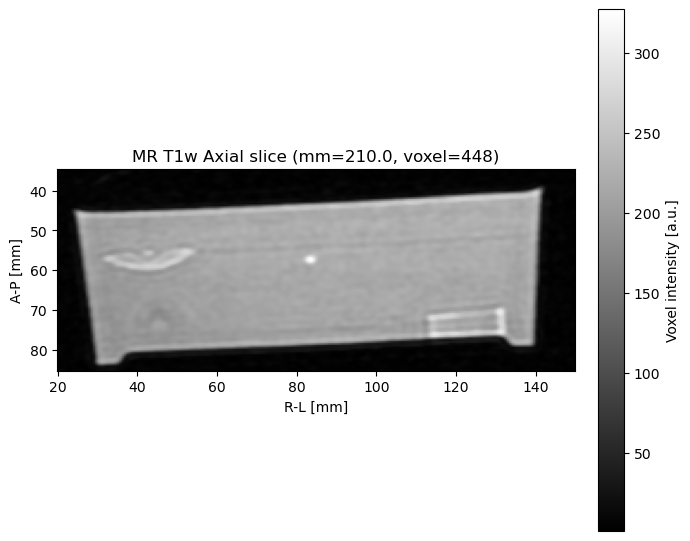

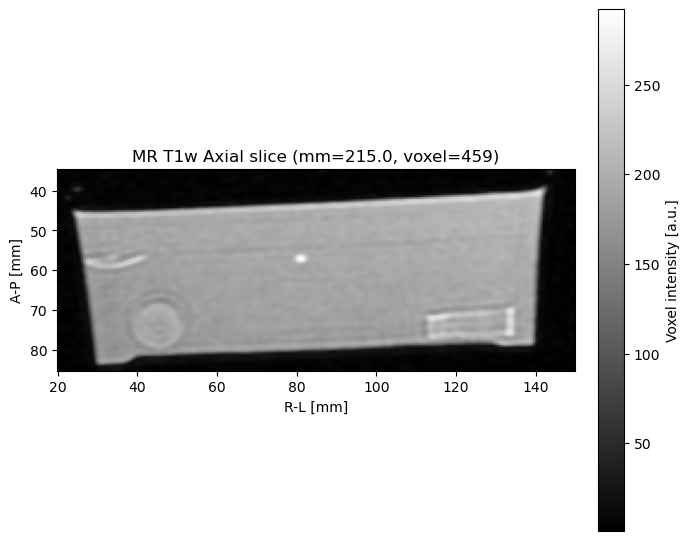

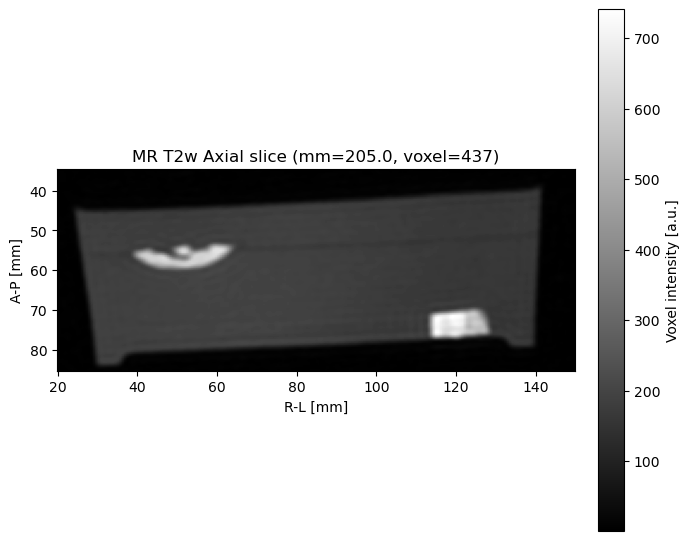

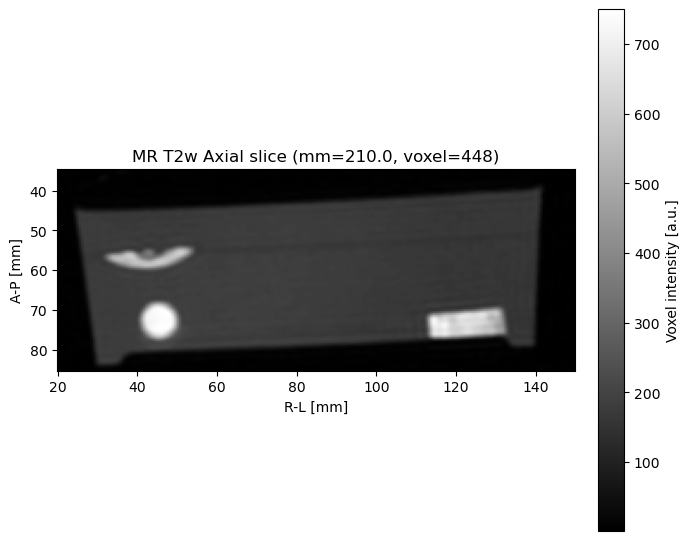

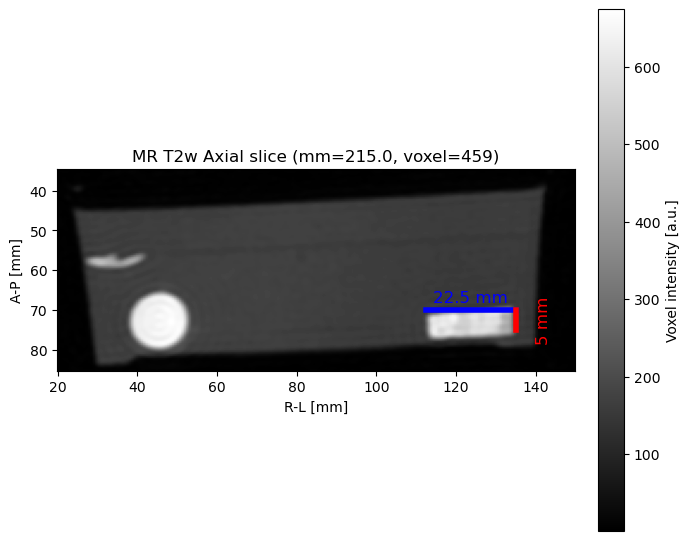

In [ ]:
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=205,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T1w_Axial1.svg"
)

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=210,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T1w_Axial2.svg"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=215,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T1w_Axial3.svg"
)

########
# T2w
########

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=205,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T2w_Axial1.svg"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=210,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T2w_Axial2.svg"
)
show_slice_with_scalebars(
    t2w_img3d, t2w_voxel,
    slice_mm=215,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    h_scalebar_mm=22.5,
    v_scalebar_mm=5,
    h_scalebar_pos_mm=(112.5+22.5/2, 70),  # horizontal scalebar at x=50 mm, y=180 mm
    v_scalebar_pos_mm=(135, 70+5/2), # vertical scalebar at x=100 mm, y=200 mm
    h_scalebar_color='blue',
    v_scalebar_color='red',
    # save_svg=True,
    # svg_filename="MRI_Cucumber_T2w_Axial3.svg"
)

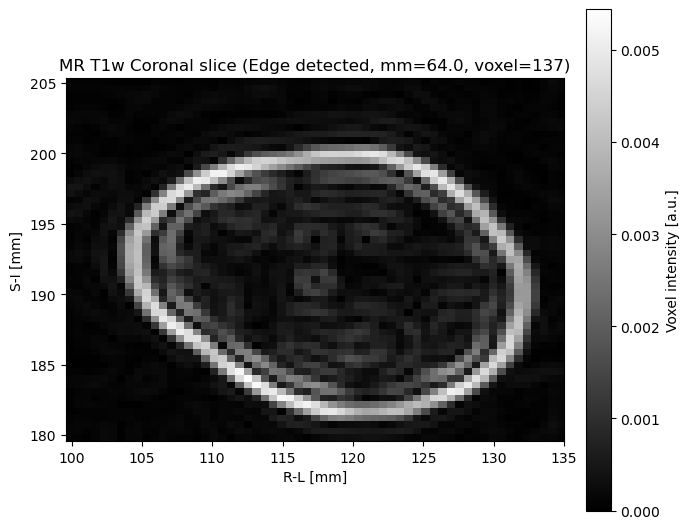

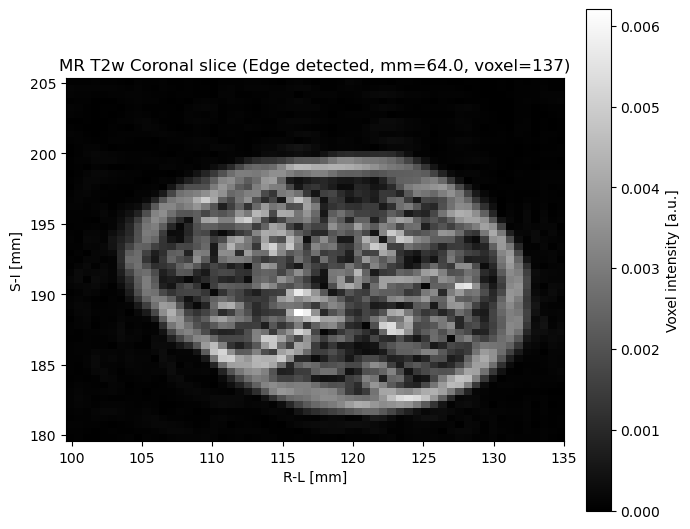

In [82]:
from skimage import filters, feature, exposure

def show_slice_edge(img3d, voxel_size, slice_mm, orientation,
               crop_AP_mm=None, crop_RL_mm=None, crop_SI_mm=None,
               colormap='gray', voxel_units="", title_prefix="", save_svg=False, svg_filename=None, canny_sigma=2):
    """
    Show ONE MRI slice (axial, sagittal, coronal) with edge detection applied.
    Optionally save as SVG.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    def mm_to_idx(mm_range, vox):
        i0 = int(np.floor(mm_range[0] / vox))
        i1 = int(np.ceil(mm_range[1]  / vox))
        return slice(i0, i1)

    crop_AP = mm_to_idx(crop_AP_mm, voxel_size[0]) if crop_AP_mm else slice(None)
    crop_RL = mm_to_idx(crop_RL_mm, voxel_size[1]) if crop_RL_mm else slice(None)
    crop_SI = mm_to_idx(crop_SI_mm, voxel_size[2]) if crop_SI_mm else slice(None)

    axis_map = {"coronal":0, "sagittal":1, "axial":2}
    slice_idx = int(round(slice_mm / voxel_size[axis_map[orientation]]))

    if orientation == "axial":
        img = img3d[crop_AP, crop_RL, slice_idx]
        extent = [
            crop_RL.start * voxel_size[1], crop_RL.stop * voxel_size[1],
            crop_AP.stop * voxel_size[0], crop_AP.start * voxel_size[0]
        ]
        xlabel, ylabel = "R-L [mm]", "A-P [mm]"

    elif orientation == "sagittal":
        img = img3d[crop_AP, slice_idx, crop_SI]
        img = np.rot90(img, 1)
        extent = [
            crop_AP.start * voxel_size[0], crop_AP.stop * voxel_size[0],
            crop_SI.start * voxel_size[2], crop_SI.stop * voxel_size[2]
        ]
        xlabel, ylabel = "A-P [mm]", "S-I [mm]"

    elif orientation == "coronal":
        img = img3d[slice_idx, crop_RL, crop_SI]
        img = np.rot90(img, 1)
        extent = [
            crop_RL.start * voxel_size[1], crop_RL.stop * voxel_size[1],
            crop_SI.start * voxel_size[2], crop_SI.stop * voxel_size[2]
        ]
        xlabel, ylabel = "R-L [mm]", "S-I [mm]"

    # Edge detection
    img_edges = filters.sobel(img)

    fig = plt.figure(figsize=(7, 7))
    im = plt.imshow(img_edges, cmap=colormap, extent=extent, aspect='equal')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title_prefix} {orientation.capitalize()} slice (Edge detected, mm={slice_mm:.1f}, voxel={slice_idx})")
    plt.colorbar(im, fraction=0.046, pad=0.04, label=voxel_units)
    plt.tight_layout()
    if save_svg and svg_filename is not None:
        fig.savefig(svg_filename, format='svg')
    plt.show()

# Usage for T1w
show_slice_edge(
    t1w_img3d, t1w_voxel,
    slice_mm=Object2SliceSearch+4,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=(100,135),
    crop_SI_mm=(180,205),
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    save_svg=True,
    svg_filename="MRI_Fig_T1w_EdgeDetection.svg"
)

# Usage for T2w
show_slice_edge(
    t2w_img3d, t2w_voxel,
    slice_mm=Object2SliceSearch+4,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=(100,135),
    crop_SI_mm=(180,205),
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    save_svg=True,
    svg_filename="MRI_Fig_T2w_EdgeDetection.svg"
)


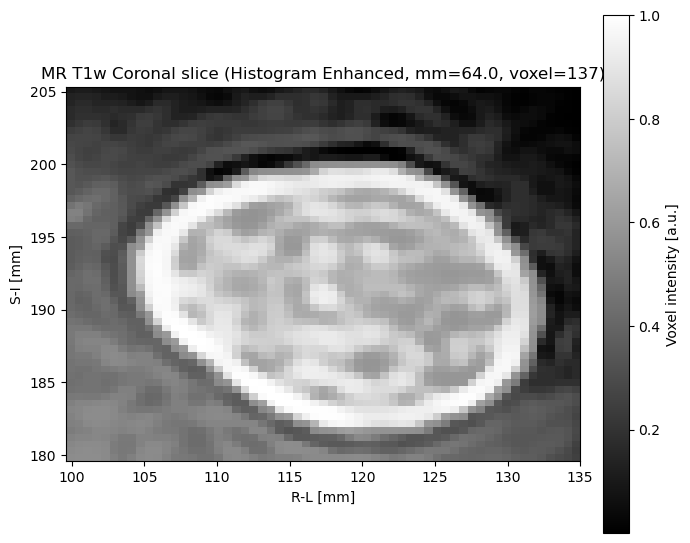

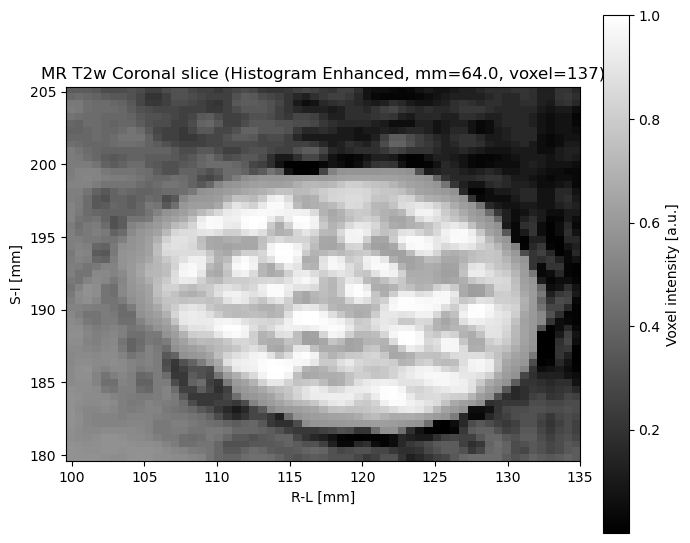

In [80]:
from skimage import exposure

def show_slice_histogram_enhanced(img3d, voxel_size, slice_mm, orientation,
               crop_AP_mm=None, crop_RL_mm=None, crop_SI_mm=None,
               colormap='gray', voxel_units="", title_prefix="", save_svg=False, svg_filename=None):
    """
    Show ONE MRI slice (axial, sagittal, coronal) with histogram contrast enhancement applied.
    Optionally save as SVG.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    def mm_to_idx(mm_range, vox):
        i0 = int(np.floor(mm_range[0] / vox))
        i1 = int(np.ceil(mm_range[1]  / vox))
        return slice(i0, i1)

    crop_AP = mm_to_idx(crop_AP_mm, voxel_size[0]) if crop_AP_mm else slice(None)
    crop_RL = mm_to_idx(crop_RL_mm, voxel_size[1]) if crop_RL_mm else slice(None)
    crop_SI = mm_to_idx(crop_SI_mm, voxel_size[2]) if crop_SI_mm else slice(None)

    axis_map = {"coronal":0, "sagittal":1, "axial":2}
    slice_idx = int(round(slice_mm / voxel_size[axis_map[orientation]]))

    if orientation == "axial":
        img = img3d[crop_AP, crop_RL, slice_idx]
        extent = [
            crop_RL.start * voxel_size[1], crop_RL.stop * voxel_size[1],
            crop_AP.stop * voxel_size[0], crop_AP.start * voxel_size[0]
        ]
        xlabel, ylabel = "R-L [mm]", "A-P [mm]"

    elif orientation == "sagittal":
        img = img3d[crop_AP, slice_idx, crop_SI]
        img = np.rot90(img, 1)
        extent = [
            crop_AP.start * voxel_size[0], crop_AP.stop * voxel_size[0],
            crop_SI.start * voxel_size[2], crop_SI.stop * voxel_size[2]
        ]
        xlabel, ylabel = "A-P [mm]", "S-I [mm]"

    elif orientation == "coronal":
        img = img3d[slice_idx, crop_RL, crop_SI]
        img = np.rot90(img, 1)
        extent = [
            crop_RL.start * voxel_size[1], crop_RL.stop * voxel_size[1],
            crop_SI.start * voxel_size[2], crop_SI.stop * voxel_size[2]
        ]
        xlabel, ylabel = "R-L [mm]", "S-I [mm]"

    # Histogram contrast enhancement
    img_enhanced = exposure.equalize_hist(img)

    fig = plt.figure(figsize=(7, 7))
    im = plt.imshow(img_enhanced, cmap=colormap, extent=extent, aspect='equal')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title_prefix} {orientation.capitalize()} slice (Histogram Enhanced, mm={slice_mm:.1f}, voxel={slice_idx})")
    plt.colorbar(im, fraction=0.046, pad=0.04, label=voxel_units)
    plt.tight_layout()
    if save_svg and svg_filename is not None:
        fig.savefig(svg_filename, format='svg')
    plt.show()

# Usage for T1w
show_slice_histogram_enhanced(
    t1w_img3d, t1w_voxel,
    slice_mm=Object2SliceSearch+4,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=(100,135),
    crop_SI_mm=(180,205),
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]",
    save_svg=True,
    svg_filename="MRI_Fig_T1w_ContrastEnhanced.svg"
)

# Usage for T2w
show_slice_histogram_enhanced(
    t2w_img3d, t2w_voxel,
    slice_mm=Object2SliceSearch+4,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=(100,135),
    crop_SI_mm=(180,205),
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]",
    save_svg=True,
    svg_filename="MRI_Fig_T2w_ContrastEnhanced.svg"
)
